<a href="https://colab.research.google.com/github/nafrielramadhan/imbalanced-classification-and-neural-network/blob/main/imbalanced_classification_and_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://drive.google.com/uc?id=1f1gGVI-rxcHjA90WEGNvvtSXF1pAxQwg" alt="Fasilkom UI" width="300"/>

CSGE603130 • Kecerdasan Artifisial dan Sains Data Dasar

Fakultas Ilmu Komputer, Universitas Indonesia

Questions answered by: Muhammad Nafriel Ramadhan
##**Topic: Imbalanced Classification & Neural Network**

</center>


# Import Library

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from numpy import where
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone

# Imbalanced Classification

Selama ini kita mempelajari metode klasifikasi dengan asumsi bahwa *dataset* yang digunakan untuk *training* seimbang. Artinya, distribusi kelas pada dataset cenderung sama. Distribusi kelas disini mengacu kepada jumlah data pada masing-masing kelas. Namun, ternyata distribusi kelas yang sama sangat jarang ditemui pada dunia nyata. Misalnya, pada sebuah problem klasifikasi apakah sebuah email spam (positif) atau tidak (negatif), email yang normal pasti lebih sering didapatkan dibanding yang spam. Ini mengakibatkan dataset yang digunakan lebih banyak distribusinya pada kelas email normal dibanding yang spam. Hal ini menyebabkan performa klasifikasi lebih terpengaruh oleh kelas yang lebih banyak **(kelas mayoritas)** padahal sebenarnya kita ingin melakukan klasifikasi pada kelas yang sedikit **(kelas minoritas)**. Dalam konteks contoh tadi, maka jika diberi sebuah email baru, model klasifikasi akan cenderung mengklasifikasikannya sebagai email yang normal **(kelas mayoritas)**.

Nah, pada lab kali ini kita akan mempelajari ***imbalanced classification***, dimana distribusi antar kelasnya tidak sama pada dataset training yang digunakan. Berdasarkan tingkat signifikansi keseimbangannya, terdapat 2 jenis imbalanced classification, yaitu:
1. Slight Imbalance: Distribusi antar kelas pada dataset training yang tidak terlalu jauh berbeda (4:6)
2. Severe Imbalance: Distribusi antar kelas pada dataset training yang lumayan jauh berbeda (1:100 atau lebih)

Perlu diperhatikan bahwa severe imbalance akan sangat mempengaruhi performa dari model klasifikasi, sehingga harus dilakukan penyeimbangan pada dataset terlebih dahulu antara kelas mayoritas dan minoritas.
Untuk mengatasi hal masalah imbalanced ini, langkah yang harus dilakukan adalah di antaranya adalah:
- Menambah sampel data pada kelas minoritas ***(Oversampling)***
, atau
- Mengurangi sampel data pada kelas mayoritas ***(Undersampling)***

Untuk mensimulasikan sebuah dataset yang imbalance, kita dapat menggunakan method `make_classification` dari library `scikit-learn`.
Berikut merupakan contoh dataset yang slight imbalance dan severe imbalance.

#### Slight Imbalance
Perbandingan data pada kelas mayoritas dan minoritas adalah 6:4

In [ ]:
# Mensimulasikan dataset slight imbalance
X_slight, y_slight = make_classification(
    n_samples=10000,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=1,
    weights=[0.6], # ratio 4:6
    flip_y=0,
    random_state=2
)

# Melihat distribusi kelas pada dataset
counter_y_slight = Counter(y_slight)
print(counter_y_slight)

Counter({0: 6000, 1: 4000})


#### Severe Imbalance
Perbandingan data pada kelas mayoritas dan minoritas adalah 99:1

In [ ]:
# Mensimulasikan dataset slight imbalance
X_severe, y_severe = make_classification(
    n_samples=10000,
    n_features=2,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    weights=[0.99], # ratio 99:1
    class_sep=0.1,
    flip_y=0,
    random_state=2
)

# Melihat distribusi kelas pada dataset
counter_y_severe = Counter(y_severe)
print(counter_y_severe)

Counter({0: 9900, 1: 100})


#### Visualisasi scatter plot slight imbalance dan severe imbalance dataset

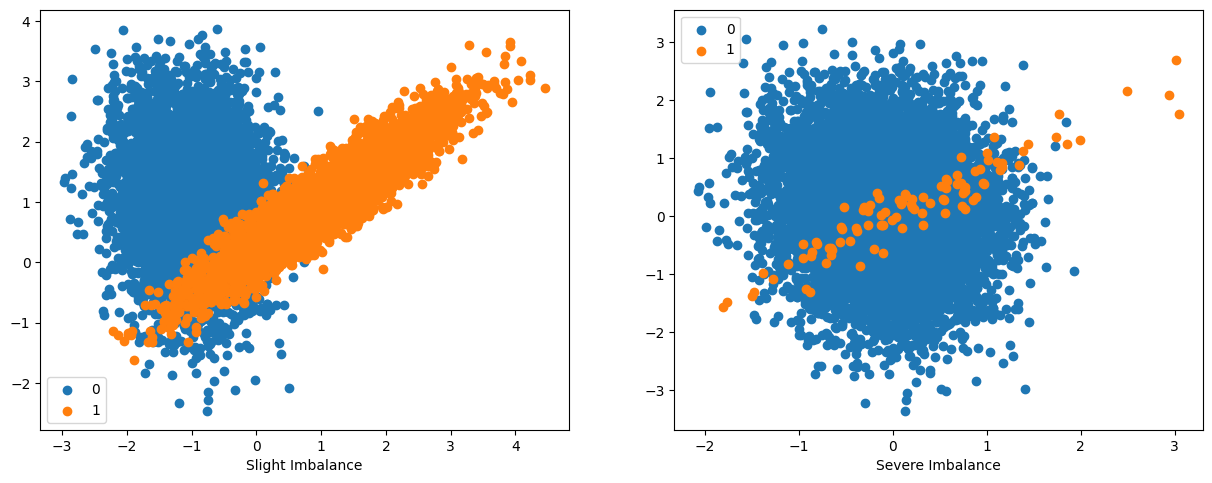

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplot(2,2,1)
plt.xlabel('Slight Imbalance')

for label, _ in counter_y_slight.items():
    row_ix = where(y_slight == label)[0]
    plt.scatter(X_slight[row_ix, 0], X_slight[row_ix, 1], label=str(label))
    plt.legend()

plt.subplot(2,2,2)
plt.xlabel('Severe Imbalance')

for label, _ in counter_y_slight.items():
    row_ix = where(y_severe == label)[0]
    plt.scatter(X_severe[row_ix, 0], X_severe[row_ix, 1], label=str(label))
    plt.legend()

plt.show()

Terlihat dengan jelas perbedaan slight imbalance dan severe imbalance pada visualisasi scatter plot di atas. Perbandingan jumlah data pada kelas mayoritas dan kelas minoritas pada severe imbalance dataset lebih besar (99:1) daripada slight imbalance dataset (6:4).

## Pengaruh Imbalance Dataset Terhadap Performa Model Klasifikasi

Imbalance dataset akan berpengaruh kepada performa model klasifikasi yang digunakan.
Kita akan menggunakan model Decision Tree dan mengevaluasi model tersebut untuk dataset slight imbalance dan severe imbalance menggunakan beberapa metriks evaluasi. Perhatikan contoh di bawah untuk memahami lebih lanjut.

1. Evaluasi Model Decision Tree Dengan Slight Imbalance Dataset

#### Metode Cross Validation
Evaluasi model di bawah ini akan menggunakan Stratified K-Fold Cross Validation dengan beberapa metrik evaluasi di antaranya: accuracy, f1 (macro), precision (macro), recall (macro).

Disini data - data sintetis hasil penambahan oversampling akan dilibatkan dalam evaluasi model, maka dari itu kita menggunakan Stratified K-Fold Cross Validation. Stratified K-Fold Cross Validation membagi dataset menjadi sejumlah k fold dataset, dimana k fold dataset itu dibagi menjadi training dan validation test dataset. Pada Stratified K-Fold Cross Validation, distribusi kelas pada setiap fold akan dibuat seproporsional mungkin, sehingga folds yang merupakan validation test dataset akan memiliki distribusi kelas yang hampir sama.

In [ ]:
classifier = DecisionTreeClassifier()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
for i in range(len(scoring)):
  score = cross_val_score(classifier, X_slight, y_slight, scoring=scoring[i], cv=cv, n_jobs=-1)
  print(f"{scoring[i]} score: {np.mean(score)}")

accuracy score: 0.9238
f1_macro score: 0.9211864006068229
precision_macro score: 0.9205292418165595
recall_macro score: 0.9199999999999999


2. Evaluasi Model Decision Tree Dengan Severe Imbalance Dataset

In [ ]:
classifier = DecisionTreeClassifier()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
for i in range(len(scoring)):
  score = cross_val_score(classifier, X_severe, y_severe, scoring=scoring[i], cv=cv, n_jobs=-1)
  print(f"{scoring[i]} score: {np.mean(score)}")

accuracy score: 0.9826
f1_macro score: 0.5421858363818571
precision_macro score: 0.5382162401153077
recall_macro score: 0.5407575757575758


Berdasarkan hasil evaluasi model di atas, bisa dilihat bahwa akurasi dari kedua dataset sangat tinggi. Dapat kita ingat lagi bahwa metriks akurasi dipengaruhi oleh semua prediksi yang benar, baik itu kelas yang mau kita prediksi di awal (positif) atau yang bukan (negatif). Pada slight imbalance, skor akurasi dan skor metriks - metriks lainnya tidak berbeda secara signifikan. Hal ini terjadi karena model klasifikasi memperoleh informasi yang cukup dari kedua buah kelas walaupun terdapat sedikit perbedaan distribusi kelas. Akibatnya, model bisa memprediksi dengan cukup baik pada kelas minoritasnya. Namun, pada severe imbalance dataset, skor recall, precision, dan f1 score jauh lebih rendah dibanding skor akurasi yang berarti model hanya akurat dalam memprediksi kelas secara keseluruhan, tetapi kurang akurat dalam memprediksi kelas minoritas. Dalam konteks imbalance dataset yang dimana kelas minoritas adalah kelas yang ingin diprediksi (positif), kita tidak bisa menggunakan metriks akurasi sebagai acuan performa model. Kelas mayoritas akan sangat mempengaruhi performa model, sehingga informasi yang didapatkan dari kelas minoritas terabaikan.

Salah satu contoh dunia nyata dari dataset dengan kelas minoritas yang ingin diprediksi adalah email yang spam dan tidak spam. Tujuan kita membuat model pada konteks permasalahan tersebut adalah dengan tepat memprediksi email spam yang masuk sebagai email spam. Namun, karena email spam jumlah datanya sedikit pada dataset (kelas minoritas), metriks akurasi tidak disarankan dipakai untuk mengevaluasi model klasifikasi dari contoh tersebut. Akurasi yang tinggi pada model klasifikasi di contoh tersebut bisa saja akibat dari banyaknya email yang non spam yang masuk yang diprediksi benar sebagai non spam. Walaupun cuman ada 5% email spam yang masuk dan anggaplah model kita gagal memprediksi semua email tersebut sebagai email spam, akurasi model kita juga tetap tinggi di angka 95%. Namun, jika kita menggunakan metriks f1 score, maka evaluasi model hanya akan mempertimbangkan email spam yang diprediksi benar sebagai email spam saja, sehingga lebih relevan dengan tujuan awal model dibuat.

![Imbalance Dataset Accuracy vs F1 Score](https://i.imgflip.com/8dfrug.jpg)

*Sumber: https://imgflip.com/i/8dfrug*


Selanjutnya, kita akan menggunakan **dataset severe imbalance** untuk mempelajari masing-masing tipe dari penanganan imbalance dataset

In [ ]:
X = X_severe
y = y_severe

In [ ]:
# Jalankan method ini yang berguna untuk memvisualisasikan dataset yang sudah disimulasikan
def show_simulated_dataset(X, y):
    counter_y = Counter(y)
    plt.figure(figsize=(12, 10))

    for label, _ in counter_y.items():
        row_ix = where(y == label)[0]
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
        plt.legend()
    plt.show()

In [ ]:
# Jalankan method ini yang berguna untuk memvisualisasikan perbandingan dua buat dataset
def show_simulated_dataset_comparison(X1, X2, y1, y2, title1='Original dataset', title2='Sampling Dataset'):
    counter_y1 = Counter(y1)
    counter_y2 = Counter(y2)
    plt.figure(figsize=(15, 12))
    plt.subplot(2,2,1)
    plt.xlabel(title1)

    for label, _ in counter_y1.items():
        row_ix = where(y1 == label)[0]
        plt.scatter(X1[row_ix, 0], X1[row_ix, 1], label=str(label))
        plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel(title2)

    for label, _ in counter_y2.items():
        row_ix = where(y2 == label)[0]
        plt.scatter(X2[row_ix, 0], X2[row_ix, 1], label=str(label))
        plt.legend()

    plt.show()

## Oversampling

Oversampling berarti **menambah sampel data yang berasal dari kelas minoritas pada dataset**. Secara metode penambahan data, oversampling dapat dibedakan menjadi 2 tipe, yaitu penduplikasian data dan pembuatan data sintetik.

Salah satu metode penduplikasian data adalah **random oversampling**, sedangkan contoh metode pembuatan data sintetik antara lain:
- Synthetic Minority Oversampling Technique (SMOTE),
- Borderline-SMOTE,
- Borderline Oversampling with SVM, dan
- Adaptive Synthetic Sampling (ADASYN).

Selanjutnya, kita akan menelusuri definisi sederhana serta implementasi kelima metode oversampling tersebut dalam dataset simulasi kita. Untuk penjelasan lebih lengkapnya, Anda dapat membaca kembali slide perkuliahan atau mencari referensi lain melalui internet.   

### Random Oversampling

Random undersampling merupakan metode penambahan data yang berada pada kelas minoritas yang dilakukan dengan menduplikasikan data yang sudah ada secara acak. Data - data baru hasil penduplikasian ini tidak akan menambah informasi baru kepada dataset.

Counter({0: 9900, 1: 9900})


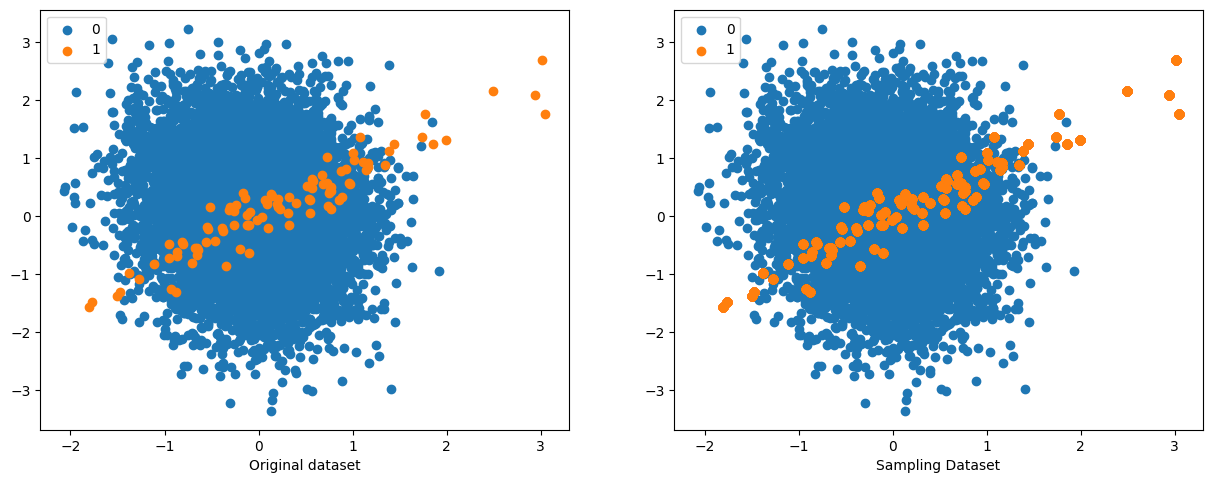

In [ ]:
# Definisi random undersampling class
rand_over = RandomOverSampler(
    sampling_strategy='minority'
)

# Resampling berdasarkan dataset simulasi
X_rand_over, y_rand_over = rand_over.fit_resample(X, y)

# Distribusi kelas pada dataset
counter_y_rand_over = Counter(y_rand_over)
print(counter_y_rand_over)

# Perbandingan scatter plot antara dataset asli dan dataset sampling
show_simulated_dataset_comparison(X1=X, X2=X_rand_over, y1=y, y2=y_rand_over)

Sekilas tidak ada perbedaan antara dataset asli dan dataset yang telah dilakukan random oversampling. Hal ini terjadi karena data pada kelas minoritas diduplikasikan pada titik yang sama, sehingga menghasilkan data data baru yang tertumpuk pada titik yang sama. Maka dari itu, tidak terlihat perbedaan antara dataset asli dan dataset sampling.

### Synthetic Minority Oversampling Technique (SMOTE)

SMOTE membentuk data baru dengan menggabungkan data pada kelas minoritas dengan data tetangganya. Data baru yang dihasilkan akan berada pada garis yang menghubungkan data asli pada kelas minoritas.

![SMOTE](https://i.ibb.co/MV143tn/Screenshot-2024-04-23-132339.png)

*Sumber: Slide Imbalance Classification KASDAD Hal.37*

Counter({0: 9900, 1: 9900})


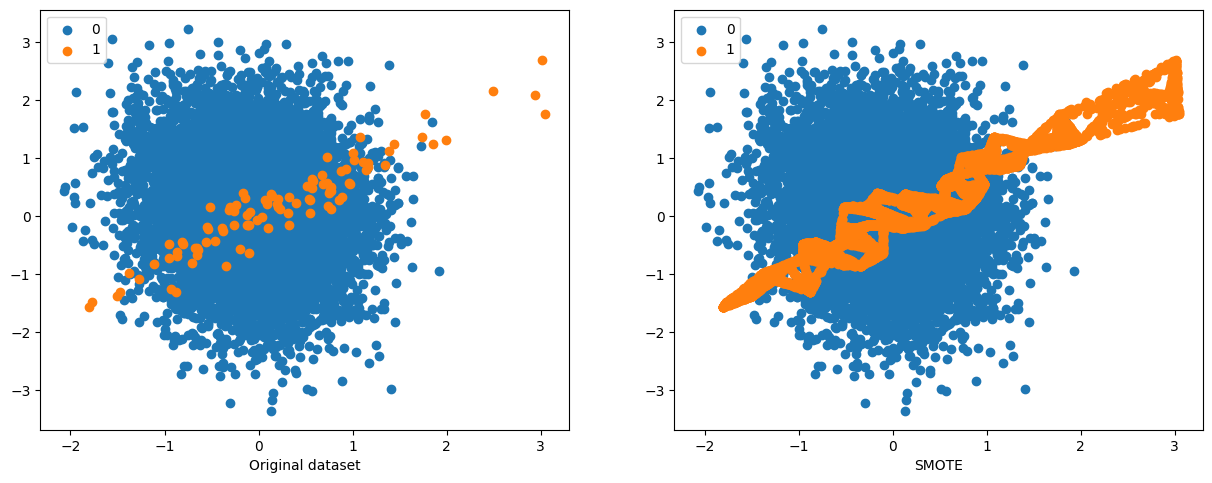

In [ ]:
# Definisi SMOTE class
smote = SMOTE()

# Resampling berdasarkan dataset simulasi
X_smote, y_smote = smote.fit_resample(X, y)

# Distribusi kelas pada dataset
counter_y_smote = Counter(y_smote)
print(counter_y_smote)

# Perbandingan scatter plot antara dataset asli dan dataset sampling
show_simulated_dataset_comparison(X1=X, X2=X_smote,
                                  y1=y, y2=y_smote,
                                  title2='SMOTE')

### Borderline-SMOTE

Variasi dari metode SMOTE yang hanya memperbanyak data sintetis pada data pada kelas minoritas yang *missclassified* sebagai kelas mayoritas, misal dengan menggunakan K-nearest neighbor model. Data - data pada kelas mintoritas yang *missclassified* ini berdekatan dengan data - data pada kelas mayoritas.  

Counter({0: 9900, 1: 9900})


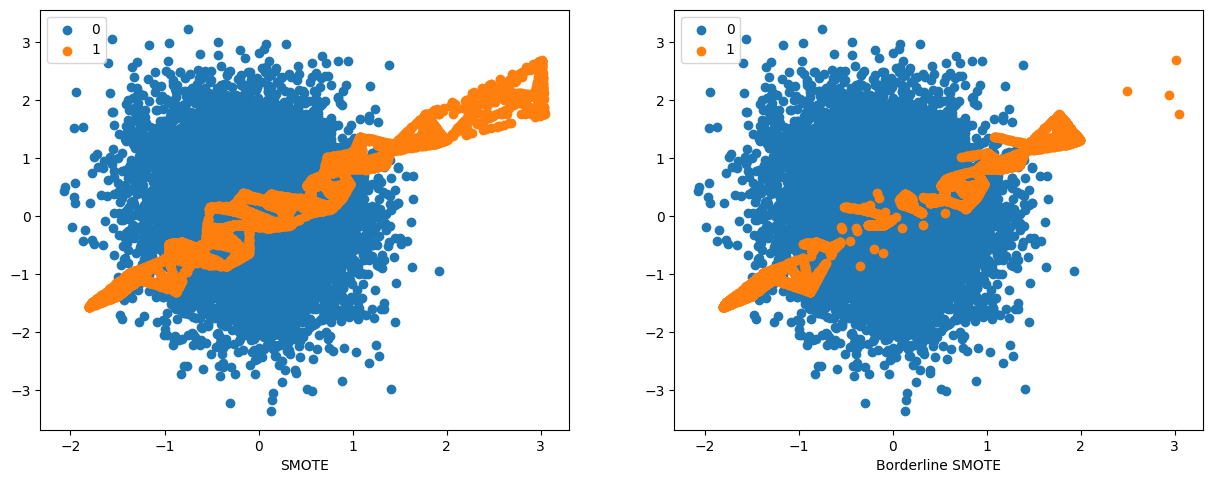

In [ ]:
# Definisi Borderline SMOTE class
borderline_smote = BorderlineSMOTE()

# Resampling berdasarkan dataset simulasi
X_borderline_smote, y_borderline_smote = borderline_smote.fit_resample(X, y)

# Distribusi kelas pada dataset
counter_y_borderline_smote = Counter(y_borderline_smote)
print(counter_y_borderline_smote)

# Perbandingan scatter plot antara dataset SMOTE dan dataset Borderline SMOTE
show_simulated_dataset_comparison(X1=X_smote, X2=X_borderline_smote,
                                  y1=y_smote, y2=y_borderline_smote,
                                  title1='SMOTE', title2='Borderline SMOTE')

### Borderline Oversampling with SVM

Dibandingkan menggunakan KNN model untuk melakukan preklasifikasi data minoritas yang akan dioversampling, metode ini menggunakan algoritma Support Vector Machine (SVM).

Counter({0: 9900, 1: 9900})


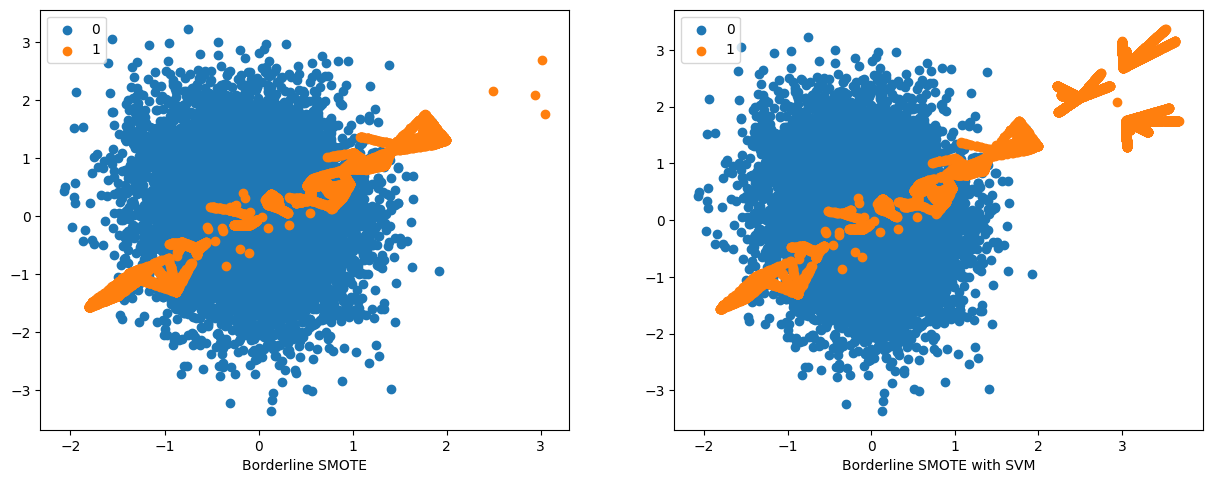

In [ ]:
# Definisi Borderline SMOTE dengan SVM class
svm_smote = SVMSMOTE()

# Resampling berdasarkan dataset simulasi
X_svm_smote, y_svm_smote = svm_smote.fit_resample(X, y)

# Distribusi kelas pada dataset
counter_y_svm_smote = Counter(y_svm_smote)
print(counter_y_svm_smote)

# Perbandingan scatter plot antara dataset Borderline SMOTE dan dataset Borderline SMOTE with SVM
show_simulated_dataset_comparison(X1=X_borderline_smote, X2=X_svm_smote,
                                  y1=y_borderline_smote, y2=y_svm_smote,
                                  title1='Borderline SMOTE', title2='Borderline SMOTE with SVM')

### Adaptive Synthetic Sampling (ADASYN)

Pendekatan lain yang melibatkan pembuatan sampel data sintetik yang berbanding terbalik dengan jumlah sampel data di kelas minoritas. Artinya, menghasilkan lebih banyak data sintetik di wilayah ruang fitur yang jumlah data pada kelas minoritasnya rendah, dan lebih sedikit atau tidak ada sama sekali jika jumlah data pada kelas minoritasnya banyak.

Counter({1: 9925, 0: 9900})


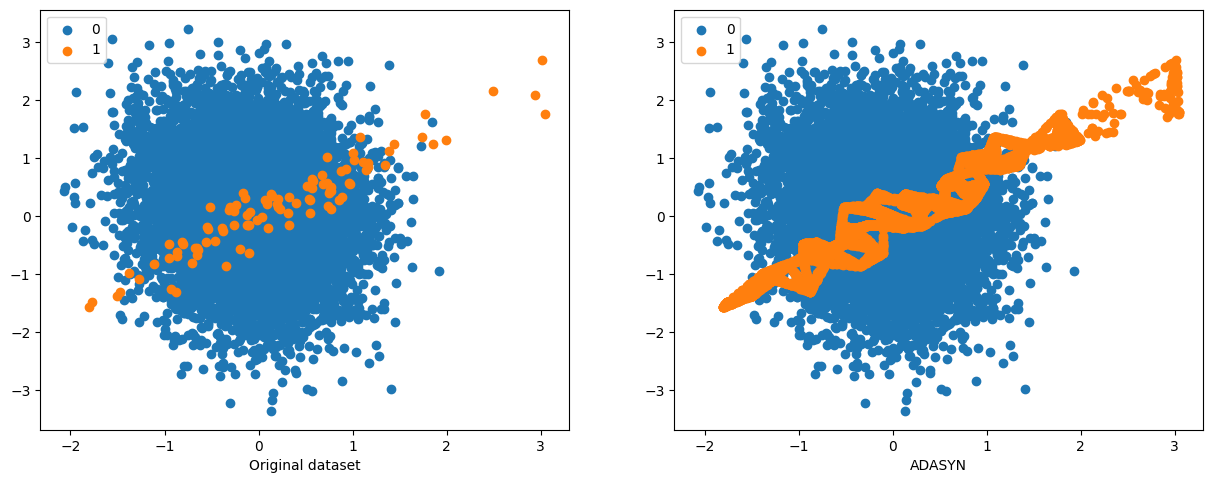

In [ ]:
# Definisi ADASYN class
adasyn = ADASYN()

# Resampling berdasarkan dataset simulasi
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

# Distribusi kelas pada dataset
counter_y_adasyn = Counter(y_adasyn)
print(counter_y_adasyn)

# Perbandingan scatter plot antara dataset asli dan dataset ADASYN
show_simulated_dataset_comparison(X1=X , X2=X_adasyn,
                                  y1=y, y2=y_adasyn,
                                  title2='ADASYN')

## Undersampling

Undersampling merupakan **mengurangi data yang berasal dari kelas mayoritas**. Tujuannya adalah sama seperti oversampling, yaitu untuk menyeimbangkan distribusi kelas pada dataset. Beberapa metode undersampling di antaranya:
- Random Undersampling,
- Near Miss Undersampling, dan
- Tomek Link Undersampling.

Mari kita telusuri satu per satu ketiga metode undersampling di atas dengan memberikan definisi sederhana dan implementasi langsungnya menggunakan dataset simulasi yang sudah ada.

### Random Undersampling

Random undersamplng akan melakukan pengambilan sampel acak dari kelas mayoritas dan menghapusnya dari dataset.

Counter({0: 100, 1: 100})


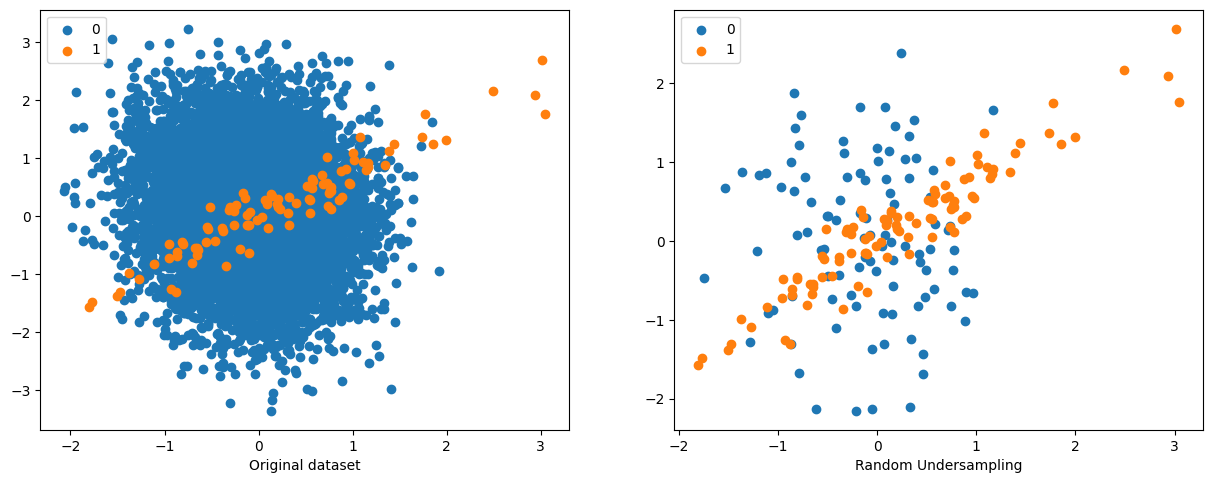

In [ ]:
# Definisi ADASYN class
rand_under = RandomUnderSampler(
    sampling_strategy='majority'
)

# Resampling berdasarkan dataset simulasi
X_rand_under, y_rand_under = rand_under.fit_resample(X, y)

# Distribusi kelas pada dataset
counter_y_rand_under = Counter(y_rand_under)
print(counter_y_rand_under)

# Perbandingan scatter plot antara dataset asli dan dataset ADASYN
show_simulated_dataset_comparison(X1=X , X2=X_rand_under,
                                  y1=y, y2=y_rand_under,
                                  title2='Random Undersampling')

### Near Miss Undersampling

Near Miss mengacu pada metode undersampling yang memilih sampel data berdasarkan jarak data pada kelas mayoritas ke data pada kelas minoritas.Terdapat tiga versi penerapan Near Miss, di antaranya:

#### NearMiss-1

Memilih sampel dari kelas mayoritas yang memiliki jarak rata-rata terkecil ke tiga sampel kelas minoritas terdekat.

Counter({0: 100, 1: 100})


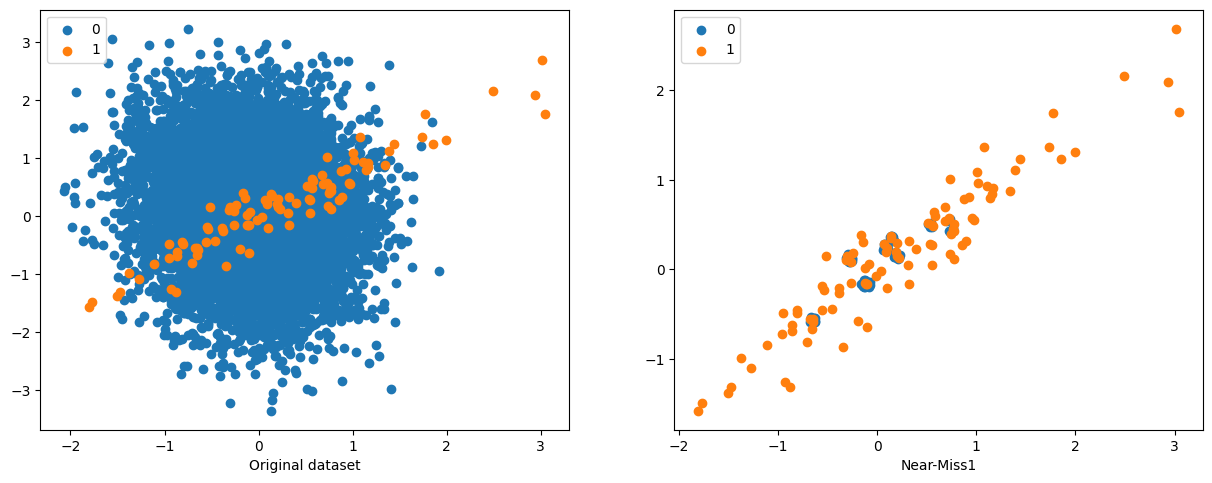

In [ ]:
# Definisi Near Miss 1 class
nearmiss = NearMiss()

# Resampling berdasarkan dataset simulasi
X_nearmiss, y_nearmiss = nearmiss.fit_resample(X, y)

# Distribusi kelas pada dataset
counter_y_nearmiss = Counter(y_nearmiss)
print(counter_y_nearmiss)

# Perbandingan scatter plot antara dataset asli dan dataset Near-Miss1
show_simulated_dataset_comparison(X1=X , X2=X_nearmiss,
                                  y1=y, y2=y_nearmiss,
                                  title2='Near-Miss1')

#### NearMiss-2

Memilih sampel dari kelas mayoritas yang memiliki jarak rata-rata terbesar ke tiga sampel kelas minoritas terdekat.

Counter({0: 100, 1: 100})


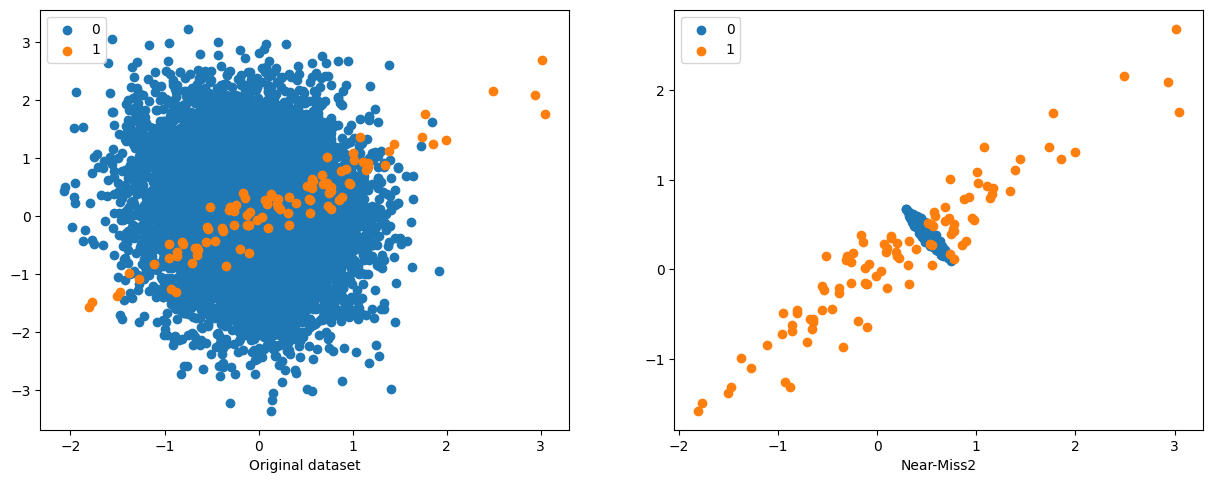

In [ ]:
# Definisi Near Miss 2 class
nearmiss2 = NearMiss(version=2)

# Resampling berdasarkan dataset simulasi
X_nearmiss2, y_nearmiss2 = nearmiss2.fit_resample(X, y)

# Distribusi kelas pada dataset
counter_y_nearmiss2 = Counter(y_nearmiss2)
print(counter_y_nearmiss2)

# Perbandingan scatter plot antara dataset asli dan dataset Near-Miss2
show_simulated_dataset_comparison(X1=X , X2=X_nearmiss2,
                                  y1=y, y2=y_nearmiss2,
                                  title2='Near-Miss2')

#### NearMiss-3

Memilih sampel dari kelas mayoritas yang memiliki jarak rata-rata terkecil ke setiap sampel kelas minoritas.

Counter({0: 100, 1: 100})


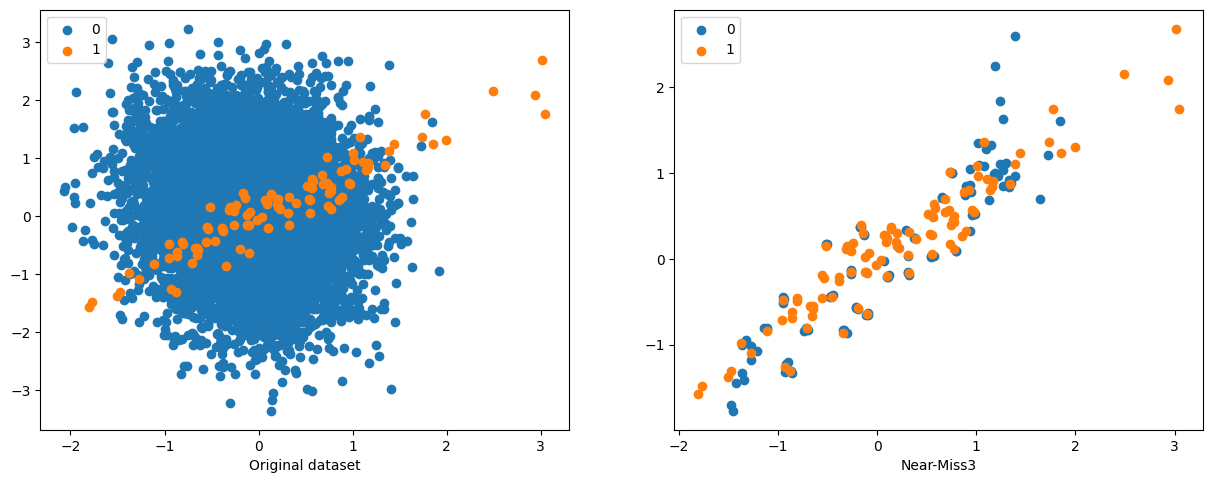

In [ ]:
# Definisi Near Miss 3 class
nearmiss3 = NearMiss(version=3)

# Resampling berdasarkan dataset simulasi
X_nearmiss3, y_nearmiss3 = nearmiss3.fit_resample(X, y)

# Distribusi kelas pada dataset
counter_y_nearmiss3 = Counter(y_nearmiss3)
print(counter_y_nearmiss3)

# Perbandingan scatter plot antara dataset asli dan dataset Near-Miss3
show_simulated_dataset_comparison(X1=X , X2=X_nearmiss3,
                                  y1=y, y2=y_nearmiss3,
                                  title2='Near-Miss3')

#### Tomek Link Undersampling

Tomek Link undersampling akan menghapus sampel kelas mayoritas yang merupakan **Tomek Link**, dimana sampel a dan b dikatakan Tomek Link jika:
1. Nearest neighbor sampel a adalah b,
2. Nearest neighbor sampel b adalah a, dan
3. Sampel a dan b berada pada kelas yang berbeda.

Counter({0: 9847, 1: 100})


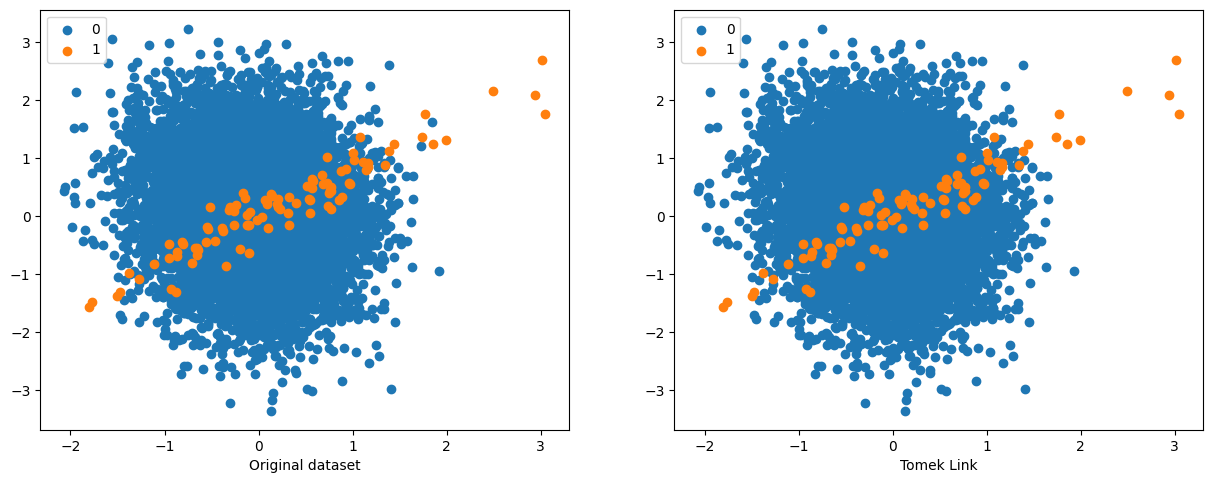

In [ ]:
# Definisi Tomek Link class
tomek = TomekLinks()

# Resampling berdasarkan dataset simulasi
X_tomek, y_tomek = tomek.fit_resample(X, y)

# Distribusi kelas pada dataset
counter_y_tomek = Counter(y_tomek)
print(counter_y_tomek)

# Perbandingan scatter plot antara dataset asli dan dataset Tomek Link
show_simulated_dataset_comparison(X1=X , X2=X_tomek,
                                  y1=y, y2=y_tomek,
                                  title2='Tomek Link')

Tomek Link hanya menghapus sedikit sampel kelas mayoritas yang berada pada borderline karena harus memenuhi ketiga syarat di atas tadi

## Cost Sensitive Learning

Dalam kasus *imbalance classification*, seperti mendeteksi email spam atau mengidentifikasi penipuan, setiap jenis kesalahan prediksi bisa memiliki konsekuensi yang berbeda-beda. Misalnya, salah mengklasifikasikan email penting sebagai spam bisa menjadi lebih buruk daripada membiarkan beberapa email spam masuk ke kotak masuk. Ini karena dampak dari kesalahan *false negative* (misalnya, melewatkan email penting) lebih besar daripada *false positive* (misalnya, menyaring email yang sebenarnya tidak spam).

Untuk menangani hal ini, ada pendekatan yang disebut cost-sensitive learning yang memperhitungkan perbedaan dalam biaya atau dampak dari kesalahan klasifikasi. Sebagai contoh, jika kita berbicara tentang kasus pembobolan bank, biaya dari tidak mendeteksi kasus penipuan bisa sangat besar. Dalam situasi seperti itu, kita ingin model kita lebih fokus pada mendeteksi kasus-kasus penipuan, bahkan jika itu berarti mengorbankan tingkat akurasi umum.

Cost-sensitive learning bisa dilakukan dengan beberapa cara. Salah satunya adalah dengan menyesuaikan kembali bobot dari sampel data untuk memperhitungkan ketidakseimbangan distribusi kelas. Misalnya, kita bisa memberi bobot lebih besar pada kelas minoritas. Metode lain melibatkan algoritma yang secara eksplisit memperhitungkan biaya kesalahan selama proses pembelajaran. Ada juga teknik yang menggunakan kombinasi dari model untuk meminimalkan biaya kesalahan secara keseluruhan.

Kali ini kita akan mempelajari cost-sensitive learning pada Decision Tree

### Cost Sensitive Decision Tree

Dengan menggunakan model Decision Tree yang pernah Anda pelajari sebelumnya, kita dapat menerapkan *cost sensitive algorithm* sebagai berikut. Mari kita lihat bagaimana performa model biasa pada dataset yang telah digenerate sebelumnya.

Pertama, mari kita evaluasi model tanpa menggunakan pembobotan kelas

In [ ]:
# Definisi model
model_1 = DecisionTreeClassifier()
# Evaluasi model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['f1_micro', 'f1_macro', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro']
for i in range(len(scoring)):
  score = cross_val_score(model_1, X, y, scoring=scoring[i], cv=cv, n_jobs=-1)
  print(f"{scoring[i]} score: {np.mean(score)}")

f1_micro score: 0.9827
f1_macro score: 0.5431321550501201
precision_micro score: 0.9822000000000001
precision_macro score: 0.5332821022877553
recall_micro score: 0.9827
recall_macro score: 0.5560101010101011


Setelah itu, lakukan evaluasi pada model decision tree yang diberikan pembobotan pada masing-masing kelasnya. Dalam kasus ini, kita akan memberikan bobot 1:99 untuk perbandingan kelas mayoritas dan kelas minoritas. Kelas minoritas memiliki bobot yang lebih tinggi.

In [ ]:
# Definisi bobot dan model
weights = {0:1, 1:99}
model_1 = DecisionTreeClassifier(class_weight=weights)

In [ ]:
model_2 = DecisionTreeClassifier(class_weight=weights)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['f1_micro', 'f1_macro', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro']
for i in range(len(scoring)):
  score = cross_val_score(model_2, X, y, scoring=scoring[i], cv=cv, n_jobs=-1)
  print(f"{scoring[i]} score: {np.mean(score)}")

f1_micro score: 0.9839
f1_macro score: 0.5681403386490483
precision_micro score: 0.9839
precision_macro score: 0.5704019007918075
recall_micro score: 0.9843
recall_macro score: 0.5613636363636363


Perhatikan skor makronya, model kedua memberikan hasil skor yang sedikit lebih baik dibanding dengan model pertama.

# Neural Network

Neural Network merupakan sebuah algoritma dalam machine learning yang bekerja mirip dengan neuron di dalam otak manusia. NN terdiri dari sejumlah neuron (unit). Salah satu jenis dari NN adalah Multi Layer Perceptron (MLP), dimana MLP terdiri dari perceptron yang disusun menjadi beberapa layer. Untuk mendapatkan gambaran mengenai NN, khususnya MLP, mari kita lihat ilustrasi di bawah ini

![Multi Layer Perceptron](https://www.researchgate.net/publication/334609713/figure/fig1/AS:783455927406593@1563801857102/Multi-Layer-Perceptron-MLP-diagram-with-four-hidden-layers-and-a-collection-of-single.jpg)

*Sumber: A Guide for Using Deep Learning for Complex Trait Genomic Prediction - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/Multi-Layer-Perceptron-MLP-diagram-with-four-hidden-layers-and-a-collection-of-single_fig1_334609713*

MLP memiliki struktur dasar yang terdiri dari tiga jenis layer:

- Input layer: Layer pertama yang memiliki neuron sebanyak jumlah fitur dalam dataset.
- Hidden Layer: Layer yang berada di antara input layer dan output layer. Hasil dari hidden layer ini akan menjadi vektor input untuk output layer atau hidden layer berikutnya.
- Output Layer: Layer yang menentukan hasil klasifikasi. Pada kasus binary classification, kita hanya membutuhkan satu neuron pada output layer karena hasilnya hanya ada 2 kemungkinan, yaitu 0 atau 1.

Tiap neuron di dalam hidden layer memiliki dua elemen, yaitu bobot (weight) dan bias. Setiap input akan dikalikan dengan bobotnya, kemudian hasilnya akan dijumlahkan. Di samping itu, terdapat juga nilai bias yang merupakan konstanta tertentu. Setelah proses penjumlahan selesai, hasilnya akan dimasukkan ke dalam fungsi aktivasi, yang nantinya akan menghasilkan keluaran (output).

Terdapat beberapa jenis fungsi aktivasi yang bisa dilihat pada ilustrasi di bawah ini
![Activation function](https://miro.medium.com/max/1400/1*p_hyqAtyI8pbt2kEl6siOQ.png)

Pada lab kali ini, kita akan menggunakan MLPClassifier yang telah tersedia pada library `scikit-learn` untuk menyelesaikan problem *binary classification* pada dataset simulasi yang sudah ada.

Kita akan membuat sebuah model MLPClassifier yang memiliki 2 hidden layer dimana masing-masing layer memiliki 30 dan 10 neuron berturut-turut. Fungsi aktivasi yang akan digunakan adalah Rectified Linear Unit (RelU)

In [ ]:
# Definisi MLPClassifier class
mlp_classifier = MLPClassifier(
    alpha=1e-5,
    hidden_layer_sizes=(30,10),
    solver='adam',
    random_state=42,
    activation='relu'
)

In [ ]:
# Evaluasi model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['f1_micro', 'f1_macro', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro']
for i in range(len(scoring)):
  score = cross_val_score(mlp_classifier, X, y, scoring=scoring[i], cv=cv, n_jobs=-1)
  print(f"{scoring[i]} score: {np.mean(score)}")

f1_micro score: 0.9902000000000001
f1_macro score: 0.5165850675366084
precision_micro score: 0.9902000000000001
precision_macro score: 0.6950990495247624
recall_micro score: 0.9902000000000001
recall_macro score: 0.51


Skor F1 pada model tersebut tidak terlalu baik yang mungkin diakibatkan karena dataset yang *imbalance*. Hal ini dapat diatasi dengan penggunaan Pipeline dimana kita menggunakan pengetahuan kita sebelumnya tentang metode sampling pada imbalance classification.

# Pipeline

Pipeline dalam machine learning adalah serangkaian langkah yang dilakukan secara berurutan untuk memproses data dan membangun model. Setiap langkah dalam pipeline mungkin melibatkan pemrosesan data, seperti pemisahan fitur dan label, normalisasi data, atau bahkan metode sampling untuk menangani ketidakseimbangan dalam data. Setelah data diproses, langkah selanjutnya biasanya adalah membangun model machine learning, seperti MLP (Multi-Layer Perceptron) untuk melakukan klasifikasi atau prediksi.

![Machine Learning Pipeline](https://i.ibb.co/rpVFqnt/Screenshot-2024-04-23-161850.png)

Dalam konteks *imbalance classification* menggunakan MLP, pipeline akan memiliki dua langkah utama, yaitu oversampling/undersampling dilanjutkan dengan klasifikasi menggunakan MLPClassifier:

Kita akan membuat pipeline yang melakukan 2 steps:
1. Melakukan oversampling menggunakan metode Borderline SMOTE with SVM pada dataset
2. Melakukan prediksi menggunakan MLPClassifier yang sudah didefinisikan di atas

In [ ]:
# Membuat pipeline
steps = [('over', SVMSMOTE()), ('model', mlp_classifier)]
pipeline = Pipeline(steps=steps)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['f1_micro', 'f1_macro', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro']
for i in range(len(scoring)):
  score = cross_val_score(pipeline, X, y, scoring=scoring[i], cv=cv, n_jobs=-1)
  print(f"{scoring[i]} score: {np.mean(score)}")

KeyboardInterrupt: 

Bisa dilihat bahwa skor makro F1 dari model MLPClassifier yang dimasukan ke dalam pipeline tersebut lebih tinggi dari MLPClassifier biasa tanpa menggunakan pipeline

# Soal

## Deskripsi Dataset

Dataset yang digunakan pada untuk lab kali ini adalah data kegagalan mesin. Kolom yang akan diprediksi pada dataset ini adalah `Machine failure` dengan 2 kelas yang berbeda, yaitu `0` untuk tidak gagal dan `1` untuk gagal. Dataset ini memiliki 9.815 sampel, 9.529 di antaranya merupakan merin yang tidak gagal `(Machine failure=0)`, sedangkan 286 di antaranya merupakan mesin yang gagal (`Machine failure=1`). Ini menunujukkan bahwa dataset ini termasuk dalam kategori *severe imbalance dataset*.

**Sumber data dan penjelasan:** https://www.kaggle.com/datasets/ikjotsingh221/machine-failure-cleaned/data

In [ ]:
# Membuka dataset
df = pd.read_csv('./machine_failure_cleaned.csv')

# menampilkan barisan teratas
df.head()

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
0,1551,42.8,0,0,0,0,0,0
1,1408,46.3,3,0,0,0,0,0
2,1498,49.4,5,0,0,0,0,0
3,1433,39.5,7,0,0,0,0,0
4,1408,40.0,9,0,0,0,0,0


In [ ]:
# Menampilkan Informasi dari keseluruhan dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9815 entries, 0 to 9814
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Rotational speed [rpm]  9815 non-null   int64  
 1   Torque [Nm]             9815 non-null   float64
 2   Tool wear [min]         9815 non-null   int64  
 3   TWF                     9815 non-null   int64  
 4   HDF                     9815 non-null   int64  
 5   PWF                     9815 non-null   int64  
 6   OSF                     9815 non-null   int64  
 7   Machine failure         9815 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 613.6 KB


## 1. DATA PREPROCESSING [20]

a) [5] Buatlah sebuah dataset baru yang terdiri dari kolom `Torque [Nm]` dan kolom `Tool wear [min]` sebagai fitur-fiturnya (X) dan kolom `Machine failure` sebagai target (y).

In [ ]:
X = df[['Torque [Nm]', 'Tool wear [min]']].to_numpy()
y = df['Machine failure'].to_numpy()

b) [3] Hitung dan tampilkan jumlah sampel pada kelas mayoritas dan kelas minoritas pada dataset yang baru dibuat.

In [ ]:
from collections import Counter

# Hitung jumlah sampel di masing-masing kelas
class_counts = Counter(y)

# Menampilkan jumlah sampel di kelas mayoritas dan minoritas
print("Jumlah sampel pada setiap kelas:")
for class_label, count in class_counts.items():
    print(f"Kelas {class_label}: {count} sampel")


Jumlah sampel pada setiap kelas:
Kelas 0: 9529 sampel
Kelas 1: 286 sampel


c) [2] Visualisasikan dataset pada soal (1a) dengan scatter plot. Berikan warna yang berbeda untuk setiap kelasnya

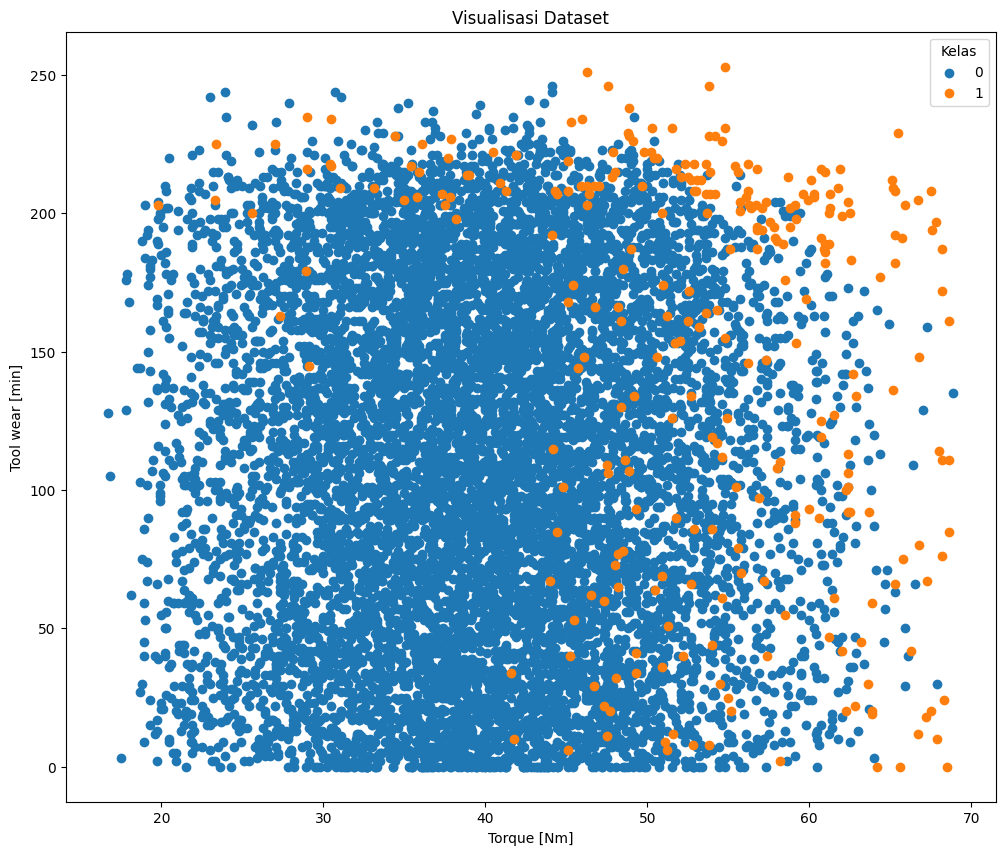

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Hitung jumlah sampel pada setiap kelas
counter = Counter(y)

# Buat plot dengan ukuran lebih besar
plt.figure(figsize=(12, 10))

# Visualisasikan setiap kelas dengan warna berbeda
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))

# Tambahkan legenda dan tampilkan plot
plt.legend(title="Kelas")
plt.xlabel('Torque [Nm]')
plt.ylabel('Tool wear [min]')
plt.title('Visualisasi Dataset')
plt.show()

d) [10] Penggunaan **Stratified K-Fold cross validation** tidak selalu menunjukkan hasil evaluasi yang sesuai dengan konteks dunia nyata. Hal ini disebabkan oleh **validation test dataset yang dibuat cenderung seimbang oleh karena tambahan data - data sintetis (oversampling)**. Pada dunia nyata, biasanya test dataset  lebih cenderung tidak seimbang. Contohnya, pada keseharian kita, email yang masuk pasti lebih banyak email yang tidak spam daripada yang spam. Oleh karena keterbatasan stratified k-fold cross validation dalam meng-handle hal tersebut, kita akan melengkapi method yang menggunakan k-fold cross validation biasa untuk evaluasi modelnya.

Lengkapi method di bawah ini dimana method ini menerima parameter - parameter berikut:

`model`: model yang akan digunakan untuk dilatih dan dievaluasi\
`X`: kumpulan kolom fitur pada dataset yang akan digunakan\
`y`: label/kelas pada dataset\
`resample_method`: metode resample (oversampling/undersampling) yang akan digunakan\
`n_splits`: banyaknya fold yang akan dipakai pada evaluasi menggunakan k-fold cross validation \

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone

def train_and_evaluate_with_oversampling(model, X, y, resample_method, n_splits=5):
    # Gunakan KFold untuk cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # List untuk menyimpan hasil skor metrik
    accuracies = []
    f1_scores = []
    precisions = []
    recalls = []

    # Iterasi untuk setiap fold dalam cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Resample data dengan metode yang diberikan
        X_train_sampled, y_train_sampled = resample_method.fit_resample(X_train, y_train)

        # Clone model agar setiap fold memiliki model yang fresh
        model_clone = clone(model)

        # Fitting model menggunakan data hasil resampling
        model_clone.fit(X_train_sampled, y_train_sampled)

        # Prediksi label untuk validation test dataset
        y_pred = model_clone.predict(X_test)

        # Hitung metrik makro
        accuracies.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average="macro"))
        precisions.append(precision_score(y_test, y_pred, average="macro"))
        recalls.append(recall_score(y_test, y_pred, average="macro"))

    # Hitung mean dari setiap list skor metrik
    mean_accuracy = sum(accuracies) / len(accuracies)
    mean_f1 = sum(f1_scores) / len(f1_scores)
    mean_precision = sum(precisions) / len(precisions)
    mean_recall = sum(recalls) / len(recalls)

    # Tampilkan mean dari setiap metrik
    print("Mean scores across all folds:")
    print(f'Mean Accuracy: {mean_accuracy:.4f}')
    print(f'Mean F1-score (macro): {mean_f1:.4f}')
    print(f'Mean Precision (macro): {mean_precision:.4f}')
    print(f'Mean Recall (macro): {mean_recall:.4f}')

    return mean_accuracy, mean_f1, mean_precision, mean_recall

Jalankan sel di bawah ini untuk mengecek apakah implementasi methodmu sudah benar atau belum. Jika masih terdapat `AssertionError` atau error lainnya, maka implementasi method masih salah

In [ ]:
import sys

clf_test = DecisionTreeClassifier()

resample_method = SMOTE()

mean_accuracy, mean_f1, mean_precision, mean_recall = train_and_evaluate_with_oversampling(clf_test, X, y, resample_method)

expected_mean_accuracy = 0.9115639327559858
expected_mean_f1_score = 0.5904853179472209
expected_mean_precision = 0.579936334077073
expected_mean_recall = 0.7363274113393764

# Tolerance 0.05
assert abs(mean_accuracy - expected_mean_accuracy) <= 0.05, f"Mean Accuracy is not within tolerance: {mean_accuracy}"
assert abs(mean_f1 - expected_mean_f1_score) <= 0.05, f"Mean F1-score is not within tolerance: {mean_f1}"
assert abs(mean_precision - expected_mean_precision) <= 0.05, f"Mean Precision is not within tolerance: {mean_precision}"
assert abs(mean_recall - expected_mean_recall) <= 0.05, f"Mean Recall is not within tolerance: {mean_recall}"

Mean scores across all folds:
Mean Accuracy: 0.9123
Mean F1-score (macro): 0.5975
Mean Precision (macro): 0.5729
Mean Recall (macro): 0.7032


Dari hasil ini, kita mendapatkan bahwa sebenarnya data memiliki akurasi yang cukup bagus (90%) namun, F-1 scorenya buruk, yaitu (59%) hal ini menandakan bahwa imbalanced data set harus ditangani.

## 2. OVERSAMPLING [30]

a) [3] Terapkan metode oversampling yang telah dipelajari pada lab ini pada dataset soal (1a). Visualisasikan scatter plot hasil resampling datasetnya

> <b><i>Metode 1</i></b> : <br>
\<Random Over Sampling\>

In [ ]:
rand_oversampler = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = rand_oversampler.fit_resample(X, y)

In [ ]:
counter = Counter(y_over)
print(counter)

Counter({0: 9529, 1: 9529})


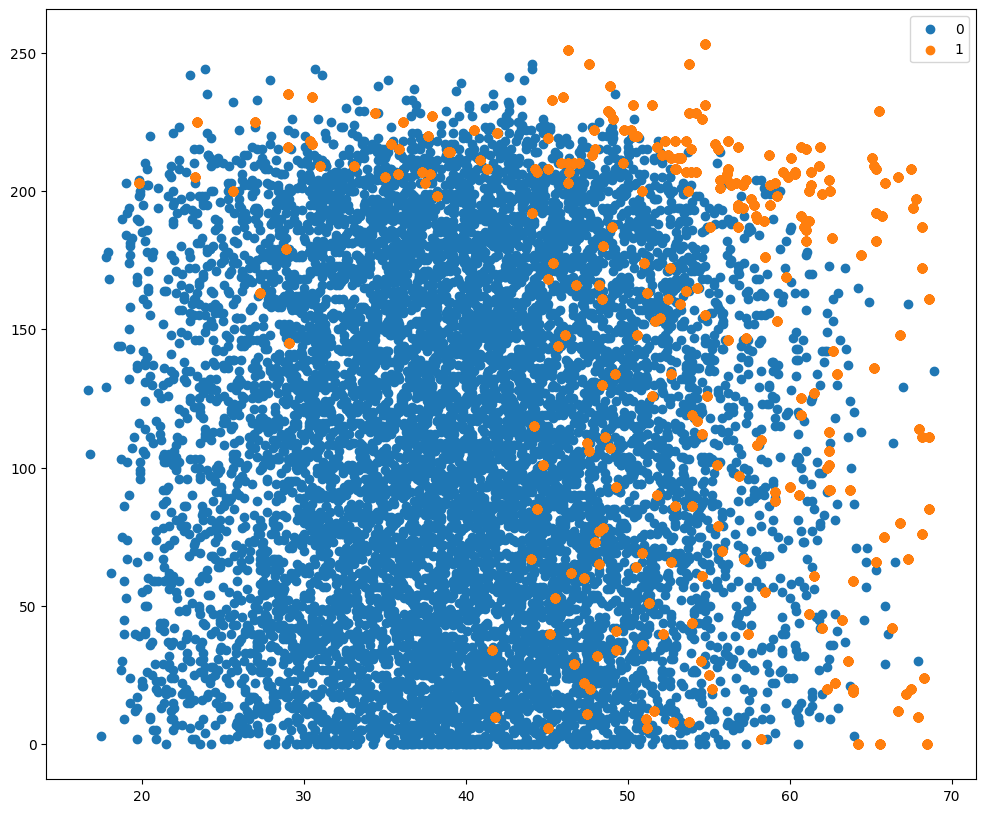

In [ ]:
plt.figure(figsize=(12, 10))

for label, _ in counter.items():
  row_ix = where(y_over == label)[0]
  plt.scatter(X_over[row_ix, 0], X_over[row_ix, 1], label=str(label))
  plt.legend()
plt.show()

b) [3] Terapkan metode oversampling yang lain yang telah dipelajari pada lab
ini pada dataset soal (1a). Visualisasikan scatter plot hasil resampling datasetnya

> <b><i>Metode 2</i></b> : <br>
\<ADASYN\>

In [ ]:
adasyn_oversampler = ADASYN()
X_adasyn, y_adasyn = adasyn_oversampler.fit_resample(X, y)

In [ ]:
counter = Counter(y_adasyn)
print(counter)

Counter({1: 9577, 0: 9529})


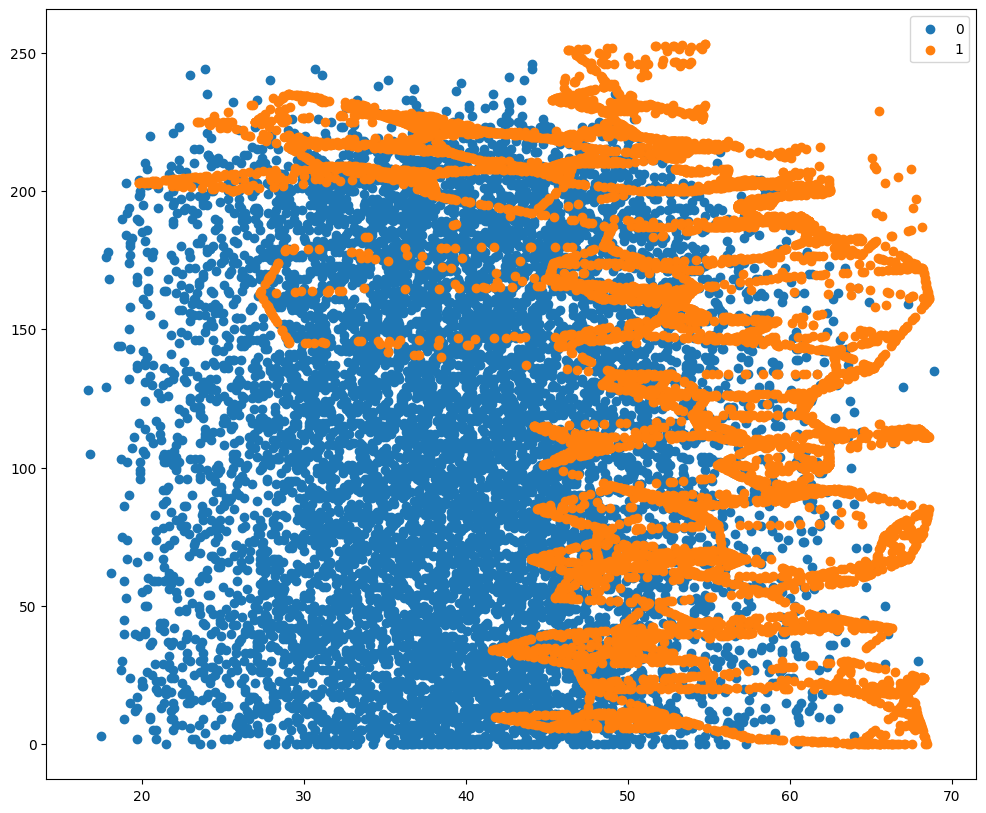

In [ ]:
plt.figure(figsize=(12, 10))

for label, _ in counter.items():
  row_ix = where(y_adasyn == label)[0]
  plt.scatter(X_adasyn[row_ix, 0], X_adasyn[row_ix, 1], label=str(label))
  plt.legend()
plt.show()

c) [5] Berdasarkan visualisasi scatter plot kedua dataset hasil resampling pada soal (2a) dan (2b) yang Anda pilih, apa perbedaan yang terlihat? Jelaskan juga mengapa perbedaan tersebut bisa terjadi!  

### **Analisa perbedaan visualisasi:**

1. **RandomOverSampler**:
    - Scatter plot menghasilkan **tampilan kelas minoritas yang lebih padat dan seragam** karena RandomOverSampler melakukan **duplikasi langsung dari sampel yang ada dalam kelas minoritas**. Yang menghasilkan banyak **titik yang bertumpuk** tepat di lokasi yang sama atau sangat dekat dengan sampel asli.
2. **ADASYN**:
    - Scatter plot menghasilkan sampel sintetik yang tidak hanya berdasarkan sampel kelas minoritas yang ada tetapi juga mempertimbangkan distribusi lokal mereka.  Jika dibandingkan dengan RandomOverSampler, scatter plot ini menunjukkan **variasi yang lebih besar dalam penyebaran sampel karena sampel baru ditambahkan** di sekitar batas keputusan antara kelas, dan membuat transisi yang lebih halus antara kelas minoritas dan mayoritas.

### **Penyebab perbedaan pada scatter plot ini terjadi karena metode yang dipakai berbeda**:

- **RandomOverSampler** bekerja dengan cara yang sangat sederhana, memilih sampel secara acak dari kelas minoritas dan menduplikasinya. Dia meningkatkan jumlah sampel tapi tidak menambah variasi baru.
- **ADASYN** bekerja dengan membuat sampel sintetik yang bukan hanya menduplikasi tetapi membuat varian baru yang diadaptasi dari sampel asli, tergantung pada kepadatan sampel dari kelas lain di sekitarnya.

d) [7] Buatlah dua buah model decision tree yang menerima dataset pada soal (1a). Lakukan evaluasi model menggunakan cross validation jenis K-fold biasa dengan k=5 dengan metriks evaluasi yang digunakan adalah f1 macro dan f1 micro. Tampilkan hasil rata-rata dari metriksnya

Dua model decision tree memiliki kriteria sbb:
- Model pertama menggunakan metode pada soal (2a) untuk oversampling training dataset di setiap iterasi cross validation
- Model kedua menggunakan metode pada soal (2b) untuk oversampling training dataset di setiap iterasi cross validation

*(Pastikan validation test dataset tidak terganggu oleh penambahan data - data sintetis.)*

<details>
<summary>HINT!!</summary>

## Perhatikan soal (1d) :D
# </details>

**Random Over Sampler**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.base import clone
import numpy as np

# Inisialisasi decision tree
tree_model_1 = DecisionTreeClassifier(random_state=42)

# K-fold cross-validation dengan 5 fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan skor metrik
f1_macro_scores = []
f1_micro_scores = []

# Inisialisasi RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)

# Loop melalui setiap fold
for train_index, test_index in kf.split(X):
    # Pisahkan data menjadi training dan test set
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Oversampling hanya pada data pelatihan
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Buat salinan model untuk setiap fold
    model_clone = clone(tree_model_1)

    # Latih model dengan data pelatihan yang telah diresample
    model_clone.fit(X_train_resampled, y_train_resampled)

    # Prediksi pada validation test set
    y_pred = model_clone.predict(X_test)

    # Hitung metrik f1 macro dan micro
    f1_macro_scores.append(f1_score(y_test, y_pred, average='macro'))
    f1_micro_scores.append(f1_score(y_test, y_pred, average='micro'))

# Hitung rata-rata skor metrik
mean_f1_macro = np.mean(f1_macro_scores)
mean_f1_micro = np.mean(f1_micro_scores)

# Tampilkan hasil
print(f"Mean F1 Macro: {mean_f1_macro:.4f}")
print(f"Mean F1 Micro: {mean_f1_micro:.4f}")


Mean F1 Macro: 0.6556
Mean F1 Micro: 0.9596


**ADASYN**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from sklearn.base import clone
import numpy as np

# Inisialisasi decision tree
tree_model_1 = DecisionTreeClassifier(random_state=42)

# K-fold cross-validation dengan 5 fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan skor metrik
f1_macro_scores = []
f1_micro_scores = []

# Inisialisasi ADASYN untuk oversampling
adasyn = ADASYN(sampling_strategy='minority', random_state=42)

# Loop melalui setiap fold
for train_index, test_index in kf.split(X):
    # Pisahkan data menjadi training dan test set
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Oversampling hanya pada data pelatihan dengan ADASYN
    X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

    # Buat salinan model untuk setiap fold
    model_clone = clone(tree_model_1)

    # Latih model dengan data pelatihan yang telah diresample
    model_clone.fit(X_train_resampled, y_train_resampled)

    # Prediksi pada validation test set
    y_pred = model_clone.predict(X_test)

    # Hitung metrik f1 macro dan micro
    f1_macro_scores.append(f1_score(y_test, y_pred, average='macro'))
    f1_micro_scores.append(f1_score(y_test, y_pred, average='micro'))

# Hitung rata-rata skor metrik
mean_f1_macro = np.mean(f1_macro_scores)
mean_f1_micro = np.mean(f1_micro_scores)

# Tampilkan hasil
print(f"Mean F1 Macro: {mean_f1_macro:.4f}")
print(f"Mean F1 Micro: {mean_f1_micro:.4f}")


Mean F1 Macro: 0.5889
Mean F1 Micro: 0.9036


e) [4] Metode manakah yang memberikan skor F1 makro tertinggi? Jelaskan!

Metode Random Over Sampler memberikan skor F1 makro yang tertinggi dengan nilai **0.6556** dibandingkan dengan ADASYN yang memiliki skor 0.5889.

Random Over Sampler menghasilkan skor F1 makro yang lebih tinggi karena metode ini secara sederhana memperbanyak sampel yang sudah ada di kelas minoritas tanpa menambahkan variasi baru, sehingga mempertahankan karakteristik asli dari kelas tersebut. Pendekatan ini memungkinkan model belajar dari lebih banyak contoh nyata di kelas minoritas, sehingga mengurangi adanya ketidakkonsistenan atau overfitting data.

ADASYN menghasilkan nilai F1 makro yang lebih sedikir karena overfitting lebih mungkin terjadi jika sampel sintetik dengan karakteristik berbeda ditambahkan.

f) [3] Buatlah sebuah model decision tree yang menerima dataset dari model dengan skor f1 makro tertinggi di soal (2d). Misalnya, jika model pertama memiliki skor tertinggi, maka dataset (X dan y) yang dipakai diambil dari soal (2a). Namun, jika model kedua memiliki skor tertinggi, maka dataset (X dan y) yang dipakai dimabil dari soal (2b). Setelah itu, lakukan evaluasi model menggunakan cross validation jenis **Stratified k-fold** dengan k=5 dengan metriks evaluasi yang digunakan adalah f1 macro dan f1 micro. Tampilkan hasil rata-rata dari metriksnya.


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler
import numpy as np

# Inisialisasi decision tree
tree_model = DecisionTreeClassifier(random_state=42)

# Inisialisasi Random Over Sampler
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)

# Oversampling dataset secara keseluruhan
X_over, y_over = oversampler.fit_resample(X, y)

# K-fold cross-validation terstratifikasi dengan 5 fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan skor metrik
f1_macro_scores = []
f1_micro_scores = []

# Loop melalui setiap fold
for train_index, test_index in skf.split(X_over, y_over):
    # Pisahkan data menjadi training dan test set
    X_train, X_test = X_over[train_index], X_over[test_index]
    y_train, y_test = y_over[train_index], y_over[test_index]

    # Latih model dengan data pelatihan
    tree_model.fit(X_train, y_train)

    # Prediksi pada validation test set
    y_pred = tree_model.predict(X_test)

    # Hitung metrik f1 macro dan micro
    f1_macro_scores.append(f1_score(y_test, y_pred, average='macro'))
    f1_micro_scores.append(f1_score(y_test, y_pred, average='micro'))

# Hitung rata-rata skor metrik
mean_f1_macro = np.mean(f1_macro_scores)
mean_f1_micro = np.mean(f1_micro_scores)

# Tampilkan hasil
print(f"Mean F1 Macro: {mean_f1_macro:.4f}")
print(f"Mean F1 Micro: {mean_f1_micro:.4f}")


Mean F1 Macro: 0.9892
Mean F1 Micro: 0.9892


g) [5] Skor f1 manakah yang lebih tinggi antara evaluasi model terbaik di soal (2d) atau (2f) secara makro maupun mikro? Berikan penjelasan jawaban Anda untuk kedua metrik makro dan mikro!

> <b><i>Jawaban</i></b> : <br>
skor F1 Macro dan F1 Micro di evaluasi model 2f lebih tinggi. Hal itu disebabkan karena:

**1. Metode K-Fold:**

2f menggunakan Stratified K-Fold, yang memastikan distribusi label yang konsisten di setiap fold. Ini membantu model untuk secara efektif mempelajari karakteristik kedua kelas karena setiap fold merefleksikan populasi dataset secara keseluruhan.

2d menggunakan Regular K-Fold, yang mungkin tidak selalu mempertahankan keseimbangan label yang sama di setiap fold. Ini dapat menyebabkan variasi dalam pembelajaran model terhadap kelas yang kurang terwakili.

**2. Penggunaan Data:**

2f melakukan oversampling pada seluruh dataset sebelum cross-validation, membuat semua data yang digunakan dalam pelatihan dan pengujian tidak imbalanced.

2d hanya melakukan oversampling pada data pelatihan setelah pembagian fold, sementara data pengujian tetap menggambarkan distribusi label asli yang imbalanced.

**Kesimpulan:**

2f menawarkan pendekatan yang lebih konsisten dan efektif dalam mengatasi isu ketidakseimbangan kelas dibandingkan 2d, yang terlihat dari skor F1 yang lebih tinggi karena konsistensi dan representasi data yang lebih baik selama proses pembelajaran model.

## 3. UNDERSAMPLING [20]

a) [3] Terapkan metode undersampling yang telah dipelajari pada lab ini pada dataset soal (1a). Visualisasikan scatter plot hasil resampling datasetnya

> <b><i>Metode 1</i></b> : <br>
\< Random Under Sampler\>

In [ ]:
random_undersampler = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = random_undersampler.fit_resample(X, y)

In [ ]:
counter = Counter(y_under)
print(counter)

Counter({0: 286, 1: 286})


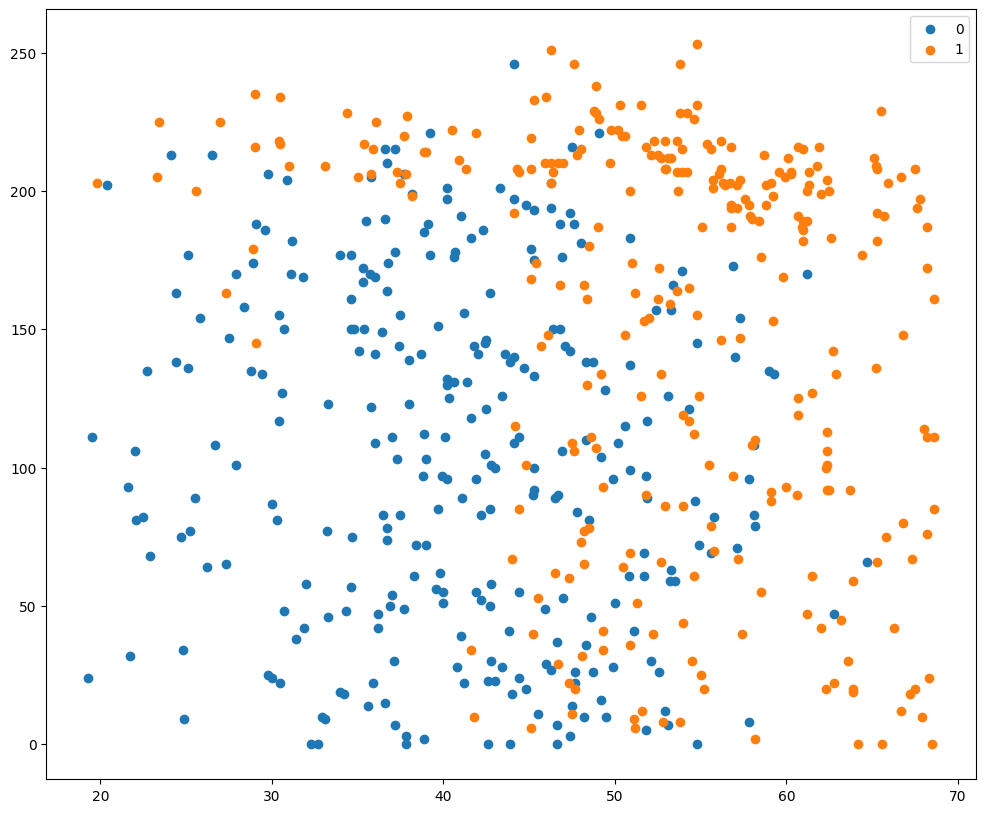

In [ ]:
plt.figure(figsize=(12, 10))

for label, _ in counter.items():
  row_ix = where(y_under == label)[0]
  plt.scatter(X_under[row_ix, 0], X_under[row_ix, 1], label=str(label))
  plt.legend()
plt.show()

b) [3] Terapkan metode undersampling yang lain yang telah dipelajari pada lab
ini pada dataset soal (1a). Visualisasikan scatter plot hasil resampling datasetnya

> <b><i>Metode 2</i></b> : <br>
\<NearMiss-2\>

In [ ]:
nearmiss2_undersampler = NearMiss(version=2)
X_nearmiss, y_nearmiss = nearmiss2_undersampler.fit_resample(X, y)

In [ ]:
counter = Counter(y_nearmiss)
print(counter)

Counter({0: 286, 1: 286})


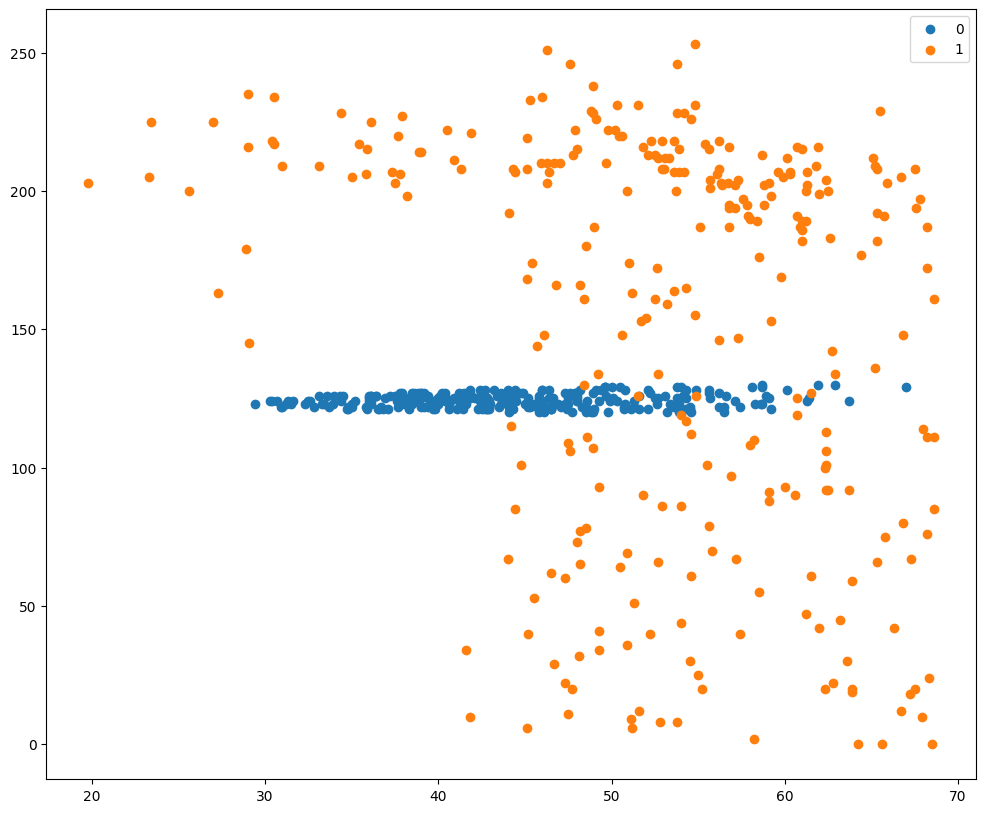

In [ ]:
plt.figure(figsize=(12, 10))

for label, _ in counter.items():
  row_ix = where(y_nearmiss == label)[0]
  plt.scatter(X_nearmiss[row_ix, 0], X_nearmiss[row_ix, 1], label=str(label))
  plt.legend()
plt.show()

c) [5] Berdasarkan visualisasi scatter plot kedua dataset hasil resampling pada soal (2a) dan (2b) yang Anda pilih, apa perbedaan yang terlihat? Jelaskan juga mengapa perbedaan tersebut bisa terjadi!

> <b><i>Jawaban</i></b> : <br>

Random Under Sampler menunjukkan distribusi yang lebih acak dan merata antara kelas, dengan kedua kelas (biru dan oren) tersebar di seluruh plot. Ini berarti pengurangan sampel dari kelas mayoritas dilakukan secara acak, tanpa mempertimbangkan kedekatan atau hubungan antar kelas, yang menjaga karakteristik distribusi asli.

NearMiss-2 memusatkan kelas biru sepanjang garis horizontal, ini karena pemilihan sampel kelas mayoritas berdasarkan kedekatan mereka terhadap kelas minoritas. Pendekatan ini membuat model untuk belajar batas keputusan yang lebih jelas, dengan mempertahankan sampel mayoritas yang berada dekat dengan minoritas, jadi ada pemisahan yang lebih baik dalam model.

d) [4] Buatlah dua buah model decision tree yang menerima dataset pada soal (2a) dan (2b) berturut - turut. Lakukan evaluasi model menggunakan cross validation jenis **Stratified K-fold** dengan k=5 dengan metriks evaluasi yang digunakan adalah f1 macro dan f1 micro. Tampilkan hasil rata-rata dari metriksnya

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

# Fungsi untuk melatih dan mengevaluasi model
def train_evaluate_model(X, y):
    # Inisialisasi model decision tree
    tree_model = DecisionTreeClassifier(random_state=42)

    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_macro_scores = []
    f1_micro_scores = []

    # Melakukan cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Latih model
        tree_model.fit(X_train, y_train)
        y_pred = tree_model.predict(X_test)

        # Hitung skor F1
        f1_macro_scores.append(f1_score(y_test, y_pred, average='macro'))
        f1_micro_scores.append(f1_score(y_test, y_pred, average='micro'))

    # Hitung rata-rata F1 skor
    mean_f1_macro = np.mean(f1_macro_scores)
    mean_f1_micro = np.mean(f1_micro_scores)

    return mean_f1_macro, mean_f1_micro

# Undersampling menggunakan Random Under Sampler dan NearMiss-2
# Asumsi X, y adalah dataset asli Anda, dan random_undersampler, nearmiss2_undersampler sudah didefinisikan dan sesuai
X_under, y_under = random_undersampler.fit_resample(X, y)
X_nearmiss, y_nearmiss = nearmiss2_undersampler.fit_resample(X, y)

# Evaluasi model untuk Random Under Sampler
mean_f1_macro_under, mean_f1_micro_under = train_evaluate_model(X_under, y_under)
print(f"Random Under Sampler - Mean F1 Macro: {mean_f1_macro_under:.4f}, Mean F1 Micro: {mean_f1_micro_under:.4f}")

# Evaluasi model untuk NearMiss-2
mean_f1_macro_nearmiss, mean_f1_micro_nearmiss = train_evaluate_model(X_nearmiss, y_nearmiss)
print(f"NearMiss-2 - Mean F1 Macro: {mean_f1_macro_nearmiss:.4f}, Mean F1 Micro: {mean_f1_micro_nearmiss:.4f}")

Random Under Sampler - Mean F1 Macro: 0.7371, Mean F1 Micro: 0.7377
NearMiss-2 - Mean F1 Macro: 0.9825, Mean F1 Micro: 0.9825


e) [5] Metode manakah yang memberikan skor F1 makro tertinggi? Jelaskan!

> <b><i>Jawaban</i></b> : <br>

F1 Makro memberikan hasil yang lebih tinggi dengan metode NearMiss-2 **(0,9825)**

Alasannya karena:
1. NearMiss-2 mengurangi kelas mayoritas dengan memilih sampel yang rata-rata
jaraknya ke kelas minoritas paling kecil. Pendekatan ini cenderung mempertahankan sampel kelas mayoritas yang paling serupa dengan kelas minoritas, sehingga meningkatkan kemampuan model untuk menggeneralisasi dari kelas minoritas ke mayoritas. Ini membantu dalam meningkatkan sensitivitas model terhadap kelas minoritas, yang secara signifikan mempengaruhi skor F1 Macro karena metrik ini memberikan bobot yang sama untuk setiap kelas.

2. NearMiss-2 memilih sampel mayoritas yang paling mirip dengan minoritas, model yang dilatih cenderung memiliki batas keputusan yang lebih baik dan lebih tepat untuk membedakan antara kelas.

3. Random Under Sampler mengurangi kelas mayoritas secara acak tanpa mempertimbangkan bagaimana sampel tersebut berhubungan dengan kelas minoritas. Hal ini bisa menghasilkan hilangnya informasi penting yang mungkin membuat model tidak mampu mempelajari distingsi antara kelas dengan baik.


## 4. COST-SENSITIVE LEARNING [15]

a) [3] Buatlah sebuah model decision tree yang menerima dataset soal (1a). Lakukan evaluasi model menggunakan cross validation jenis **Stratified K-fold** dengan k=5 dengan metriks evaluasi yang digunakan adalah f1 macro dan f1 micro. Tampilkan hasil rata-rata dari metriknya

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['f1_micro', 'f1_macro', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro']
for i in range(len(scoring)):
  score = cross_val_score(decision_tree, X, y, scoring=scoring[i], cv=cv, n_jobs=-1)
  print(f"{scoring[i]} score: {np.mean(score)}")

f1_micro score: 0.9633214467651554
f1_macro score: 0.6772931427825204
precision_micro score: 0.9633214467651554
precision_macro score: 0.675595333109665
recall_micro score: 0.9633214467651554
recall_macro score: 0.681111630477616


b) [5] Apakah ada perbedaan terhadap skor f1 makro dan mikronya? Jelaskan!

> <b><i>Jawaban</i></b> : <br>

Iya ada perbedaan.
f1_micro score: 0.9633214467651554
F1 Micro menghitung F1 score dengan menggabungkan hasil dari semua kelas menjadi satu, menghitung total true positives, false negatives, dan false positives sebelum menghitung nilai F1.

Skor F1 Micro yang tinggi menunjukkan bahwa model Anda sangat efektif secara keseluruhan dalam membuat prediksi yang tepat, terutama karena ini mencerminkan **kinerja model pada kelas yang dominan atau mayoritas**


f1_macro score: 0.6772931427825204
F1 Macro menghitung F1 score secara terpisah untuk masing-masing kelas, lalu menghitung rata-rata dari nilai-nilai tersebut tanpa mempertimbangkan proporsi masing-masing kelas.

Skor yang rendah pada F1 Macro menunjukkan bahwa model memiliki performa yang tidak baik pada kelas minoritas. Ini dapat menunjukkan bahwa meskipun model sangat baik dalam mengklasifikasikan kelas mayoritas, tapi **tidak seefektif itu dalam mendeteksi kelas minoritas (kasus mesin yang gagal)**.

Hal ini bisa terjadi karena dataset yang kita milik bersifat severe imbalanced.

c) [3] Buatlah sebuah model decision tree dengan pembobotan yang menerima dataset soal (1a). Gunakan bobot (weight) sebesar 2:1 untuk perbandingan kelas mayoritas dan minoritas. Lakukan evaluasi model menggunakan cross validation jenis **Stratified K-fold** dengan k=5 dengan metriks evaluasi yang digunakan adalah f1 macro dan f1 micro. Tampilkan hasil rata-rata dari metriksnya

In [ ]:
weight = {0: 2, 1: 1}

decision_tree = DecisionTreeClassifier(class_weight=weight, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['f1_micro', 'f1_macro', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro']
for i in range(len(scoring)):
  score = cross_val_score(decision_tree, X, y, scoring=scoring[i], cv=cv, n_jobs=-1)
  print(f"{scoring[i]} score: {np.mean(score)}")

f1_micro score: 0.9631176770249616
f1_macro score: 0.6762511165376065
precision_micro score: 0.9631176770249616
precision_macro score: 0.6745845500208912
recall_micro score: 0.9631176770249616
recall_macro score: 0.6791837864800258


d) [5] Bagaimana perbedaan skor f1 mikro pada model nomor soal (4a) dan (4c) di atas? Jelaskan hubungan skor f1 makro dengan bobot yang diberikan pada model yang lebih besar pada kelas mayoritas!

> <b><i>Jawaban</i></b> : <br>

Sebelum di beri bobot:
f1_macro score: 0.6772931427825204

setelah diberi bobot 2 (mayoritas): 1 (minoritas)
f1_macro score: 0.6762511165376065

Hasilnya tidak jauh beda. masih di angka 0,67. Bahkan hasil setelah diberi bobot, f1 macro-nya lebih kecil. Hal ini terjadi karena: seharusnya pembobotan ini diberikan kepada kelas minoritas dengan tujuan supaya model bisa lebih sensitif kepada model minoritas. Pada kasus ini dataset bersifat severe imbalanced yang ratio antara kelas mayoritas dan kelas minoritas sangat jauh. Sedangkan di nomor 4c kita malah memberikan bobot pada kelas mayoritas, sehingga hal ini tidak meningkatkan nilai f1 macro. Bobot yang diberikan pun sedikit, tidak sebanding dengan ratio ketidakseimbangan dataset-nya sehingga perbedaan nilai pada 4a dan 4c pun sangat sedikit.

## 5. NEURAL NETWORK WITH PIPELINE [25]

a) [3] Buatlah sebuah model MLPClassifier dengan kriteria sebagai berikut:
- Memiliki 3 hidden layer dengan masing - masing layer terdiri dari 50, 30, dan 10 berturut - turut
- Menggunakan fungsi aktivasi relu
- Menggunakan learning rate sebesar 0.001
- Menggunakan stochastic gradient descent sebagai algoritma pencari nilai weight dan bias

In [ ]:
classifier = MLPClassifier(
    hidden_layer_sizes=(50,30,10),
    activation='relu',
    learning_rate_init=0.001,
    solver='sgd',
    random_state=42
)

b) [3] Buatlah sebuah model MLPClassifier dengan kriteria sebagai berikut:
- Memiliki 2 hidden layer dengan masing - masing layer terdiri dari 100 dan 50 berturut - turut
- Menggunakan fungsi aktivasi relu
- Menggunakan learning rate sebesar 0.01
- Menggunakan adam sebagai algoritma pencari nilai weight dan bias

In [ ]:
classifier2 = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    learning_rate_init=0.01,
    solver='adam',
    random_state=42
)

c) [4] Evaluasi kedua model tersebut memakai dataset soal (1a) dengan menggunakan cross validation jenis **Stratified K-fold** dengan k=5 dengan metrik evaluasi yang digunakan adalah f1 macro dan f1 micro. Tampilkan hasil rata-rata dari metriknya

In [ ]:
steps = [('model', classifier)]
pipeline = Pipeline(steps=steps)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['f1_micro', 'f1_macro']
for i in range(len(scoring)):
  score = cross_val_score(pipeline, X, y, scoring=scoring[i], cv=cv, n_jobs=-1)
  print(f"{scoring[i]} score: {np.mean(score)}")

f1_micro score: 0.9708609271523179
f1_macro score: 0.4926075214569819


In [ ]:
steps = [('model', classifier2)]
pipeline = Pipeline(steps=steps)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['f1_micro', 'f1_macro']
for i in range(len(scoring)):
  score = cross_val_score(pipeline, X, y, scoring=scoring[i], cv=cv, n_jobs=-1)
  print(f"{scoring[i]} score: {np.mean(score)}")

f1_micro score: 0.9738155883851249
f1_macro score: 0.6052453662647251


d) [4] Apakah terdapat perbedaan skor metrik makro evaluasi model pada soal (4c)? Jelaskan keterkaitan perbedaan skor dengan perbedaan hyperparameter kedua model!  


> <b><i>Jawaban</i></b> : <br>

**classifier 4a:**

f1_micro score: 0.9708609271523179

f1_macro score: 0.4926075214569819

**classifier 4b:**

f1_micro score: 0.9738155883851249

f1_macro score: 0.6052453662647251

**Penjelasan:**
1. **Hidden Layer Sizes**:
    **Model Pertama**: Banyak lapisan dengan ukuran yang lebih kecil  menyebabkan model lebih kompleks dan lebih lambat untuk beradaptasi, terutama dengan solver sgd yang relatif lebih sederhana dan learning rate yang rendah.

    **Model Kedua**: Hanya dua lapisan tetapi ukuran yang lebih besar, model ini memiliki kapasitas yang cukup untuk mempelajari pola yang lebih kompleks dengan lebih cepat, yang didukung oleh solver Adam yang efisien.
2. **Solver**:
    **SGD**: Cenderung membutuhkan lebih banyak waktu dan iterasi untuk konvergensi, tidak efektif dalam menangani dataset yg severe imbalanced. Terlihat dari skor F1 Macro yang lebih rendah pada model pertama.
    
    **Adam**: Lebih efisien menemukan minimum lokal yang optimal dengan cara adaptif mengatur learning rates berdasarkan estimasi momen pertama dan kedua dari gradien, dapat lebih baik mempelajari dataset yg severe imbalanced.
3. **Learning Rate**:
    **Model Pertama**: Learning rate rendah membuat proses learning terlalu lambat, terutama jika menggunakan SGD, yang tidak cukup cepat menyesuaikan bobot untuk mengenali kelas minoritas dengan efektif.
    
    **Model Kedua**: Learning rate tinggi, terutama dengan Adam yang mengatur learning rates secara adaptif, lebih efektif dalam mempercepat pembelajaran dan menanggapi ketidakseimbangan.

Sehingga F1 macro dan F1 micro dengan classifier 4b lebih tinggi.

e) [3] Dengan menggunakan Pipeline, evaluasi sebuah model menggunakan cross validation dengan jenis **Stratified K-fold** yang melakukan oversampling dataset memakai metode SVMSMOTE terlebih dahulu sebelum dataset masuk ke model MLPClassifier. Gunakan model MLPClassifier yang memiliki skor f1 makro tertinggi dari soal (4a) dan (4b)

In [ ]:
# svm_smote = SVMSMOTE()
# X_svm_smote, y_svm_smote = svm_smote.fit_resample(X, y)

In [ ]:
# counter = Counter(y_svm_smote)
# print(counter)

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 10))

# for label, _ in counter.items():
#     row_ix = where(y_svm_smote == label)[0]
#     plt.scatter(X_svm_smote[row_ix, 0], X_svm_smote[row_ix, 1], label=str(label))

# plt.legend()
# plt.show()

In [ ]:
# steps = [('model', classifier2)]
# pipeline = Pipeline(steps=steps)

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# scoring = ['f1_micro', 'f1_macro']
# for i in range(len(scoring)):
#   score = cross_val_score(pipeline, X_svm_smote, y_svm_smote, scoring=scoring[i], cv=cv, n_jobs=-1)
#   print(f"{scoring[i]} score: {np.mean(score)}")

In [ ]:
# Membuat pipeline
steps = [('Over', SVMSMOTE()), ('model', classifier2)]
pipeline = Pipeline(steps=steps)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['f1_micro', 'f1_macro']
for i in range(len(scoring)):
  score = cross_val_score(pipeline, X, y, scoring=scoring[i], cv=cv, n_jobs=-1)
  print(f"{scoring[i]} score: {np.mean(score)}")

f1_micro score: 0.8853795211411107
f1_macro score: 0.5951816303623703


f) [3] Dengan menggunakan Pipeline, evaluasi sebuah model yang melakukan undersampling dataset menggunakan Random undersampling terlebih dahulu sebelum dataset masuk ke model MLPClassifier. Gunakan model MLPClassifier yang memiliki skor f1 makro tertinggi dari soal (4a) dan (4b)

Model undersampling dengan metode random under sampler sudah saya lakukan pada nomor 3A.

In [ ]:
# Membuat pipeline
steps = [('Under', RandomUnderSampler(sampling_strategy='majority')), ('model', classifier2)]
pipeline = Pipeline(steps=steps)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['f1_micro', 'f1_macro']
for i in range(len(scoring)):
  score = cross_val_score(pipeline, X, y, scoring=scoring[i], cv=cv, n_jobs=-1)
  print(f"{scoring[i]} score: {np.mean(score)}")

f1_micro score: 0.7577177789098318
f1_macro score: 0.4012623270943239


g) [5] Berdasarkan skor metrik evaluasi model pada soal (4e) dan (4f), jelaskan pengaruh pemilihan metode resampling antara oversampling atau undersampling terhadap model MLPClassifier! Apakah pemilihan tersebut juga berpengaruh kepada model - model klasifikasi lainnya?  

> <b><i>Jawaban</i></b> : <br>

**Dengan Oversampling (SVMSMOTE):**

F1_micro score: 0.8853795211411107

F1_macro score: 0.5951816303623703

Hasil skor lebih tinggi, terutama dalam f1_micro, artinya model lebih baik dalam memprediksi kelas-kelas mayoritas dan minoritas secara keseluruhan. F1 macro juga lebih tinggi dibandingkan dengan random under sampler. SVMSMOTE cenderung menghasilkan sampel-sampel sintetis yang lebih baik dalam mewakili kelompok minoritas, sehingga model bisa mempelajari pola-pola yang lebih baik.

**Dengan Undersampling (RandomUndersampler):**

F1_micro score: 0.7577177789098318

F1_macro score: 0.4012623270943239

Hasil skor lebih rendah, menunjukkan bahwa model mengalami kesulitan dalam mempelajari pola-pola yang ada dalam dataset karena jumlah sampel dalam kelas mayoritas telah dikurangi secara signifikan. Ini mengakibatkan hilangnya informasi yang penting dan membuat model sulit dalam membedakan antara kelas-kelas.

**Dari bukti di atas, kita bisa menyimpulkan bahwa pemilihan metode resampling berpengaruh pada model2 klasifikasi lainnya**. Karena, Setiap model klasifikasi memiliki kekuatan dan kelemahan tertentu dalam menangani imbalanced dataset, dan penggunaan oversampling atau undersampling dapat berdampak pada performa model secara keseluruhan karena setiap model resampling akan berpengaruh pada data yang dipakai untuk model klasifikasi yang kita buat nantinya. Misalnya, model klasifikasi Decision Tree atau Random Forest, oversampling dapat membantu model untuk mempelajari pola-pola yang lebih baik dalam data minoritas, sementara undersampling dapat mengurangi kompleksitas model dan mempercepat waktu komputasi.

# KAGGLE COMPETITION

Dalam rangka menerapkan pemahaman kalian pada materi imbalance classification dan neural network, kalian **diwajibkan** untuk mengikuti Kaggle Competition yang akan diadakan bersamaan dengan Lab 7 ini.

**Bagaimana Cara Mengikuti?**
*   Kalian akan menemukan tautan ke kompetisi di bagian bawah section ini atau kalian juga dapat mengaksesnya melalui laman course KASDAD pada SCELE. Klik tautan tersebut untuk mengakses halaman kompetisi. Anda dapat mengunduh dataset yang digunakan dari halaman kompetisi tersebut.
*   Kerjakan solusi Anda menggunakan notebook ini. Anda dibebaskan untuk menambahkan cell code dan markdown sesuai kebutuhan.
*   Unggah hasil prediksi Anda ke dalam kompetisi Kaggle yang telah disediakan. Format dari submission telah dispesifikasikan pada bagian **Submission File** di laman Kaggle.

**Tautan Kaggle Competition**
*   [Kaggle Competition Imbalance Classification Dan Neural Network](https://www.kaggle.com/t/a92310381f584afcbf4bdc69e60da6cb)

Dataset yang digunakan pada kompetisi ini adalah dataset klaim asuransi pada insiden kecelakaan mobil. Dataset ini digunakan untuk memprediksi apakah sebuah klaim asuransi pada insiden kecelakaan mobil palsu *(fraud)* atau bukan.

Berikut adalah penjelasan masing-masing fitur.

- **claim_number**: nomor unik klaim
- **age_of_driver**: umur pengemudi
- **safty_rating**: tingkat keamanan dari penumpang dari mobil ketika mobil mengalami insiden kecelakaan (semakin besar semakin aman)
- **annual_income**: penghasilan pemilik mobil yang diasuransikan
- **living_status**: status kepemilikan tempat tinggal (Rent, Own)
- **vehicle_category**: kategori mobil
- **vehicle_price**: harga mobil
- **fraud**: penipuan (1) atau bukan (0) -> variabel target

In [ ]:
import pandas as pd

train_data = pd.read_csv('car_claim_fraud_training.csv')

train_data.head()

,claim_number,age_of_driver,safty_rating,annual_income,living_status,vehicle_category,vehicle_price,fraud
0,15474,55,82,40065,Rent,Large,46191.49970,1
1,20972,29,34,33670,Rent,Large,18166.25089,0
2,27000,33,93,34974,Own,Large,16125.05635,0
3,27275,51,77,39310,Own,Medium,28518.94641,0
4,18966,42,47,37384,Own,Medium,12509.03330,0


In [ ]:
test_data = pd.read_csv('car_claim_fraud_test.csv')

test_data.head()

,claim_number,age_of_driver,safty_rating,annual_income,living_status,vehicle_category,vehicle_price
0,8425,32,72,34648,Own,Medium,23342.38234
1,16925,54,78,39879,Own,Large,11143.39974
2,14484,46,64,38280,Rent,Large,14540.32423
3,6428,43,71,37626,Rent,Medium,26189.97416
4,14903,57,57,40461,Own,Large,18808.00665


In [ ]:
missing_data_train = train_data.isnull().mean() * 100
missing_data_test = test_data.isnull().mean() * 100

missing_data_train, missing_data_test

(claim_number        0.0
 age_of_driver       0.0
 safty_rating        0.0
 annual_income       0.0
 living_status       0.0
 vehicle_category    0.0
 vehicle_price       0.0
 fraud               0.0
 dtype: float64,
 claim_number        0.0
 age_of_driver       0.0
 safty_rating        0.0
 annual_income       0.0
 living_status       0.0
 vehicle_category    0.0
 vehicle_price       0.0
 dtype: float64)

In [ ]:
train_data.head()

,claim_number,age_of_driver,safty_rating,annual_income,living_status,vehicle_category,vehicle_price,fraud
0,15474,55,82,40065,Rent,Large,46191.49970,1
1,20972,29,34,33670,Rent,Large,18166.25089,0
2,27000,33,93,34974,Own,Large,16125.05635,0
3,27275,51,77,39310,Own,Medium,28518.94641,0
4,18966,42,47,37384,Own,Medium,12509.03330,0


In [ ]:
test_data.head()

,claim_number,age_of_driver,safty_rating,annual_income,living_status,vehicle_category,vehicle_price
0,8425,32,72,34648,Own,Medium,23342.38234
1,16925,54,78,39879,Own,Large,11143.39974
2,14484,46,64,38280,Rent,Large,14540.32423
3,6428,43,71,37626,Rent,Medium,26189.97416
4,14903,57,57,40461,Own,Large,18808.00665


In [ ]:
X = train_data[['annual_income', 'vehicle_price']].to_numpy()
y = train_data['fraud'].to_numpy()


In [ ]:
counter_y = Counter(y)
print(counter_y)

Counter({0: 12904, 1: 2394})


data nya imbalanced. penipuan (1) atau bukan (0)

In [ ]:
# Definisi MLPClassifier class
classifier3 = MLPClassifier(
    alpha=1e-5,
    hidden_layer_sizes=(100,50),
    solver='adam',
    random_state=42,
    activation='relu',
    learning_rate_init=0.01
)

In [ ]:
DecisionTreeK = DecisionTreeClassifier()

In [ ]:
stepsK = [('over', RandomOverSampler(sampling_strategy='minority')), ('model', DecisionTreeK)]
pipelineK = Pipeline(steps=stepsK)
# Evaluasi model
for i in range(len(scoring)):
  score = cross_val_score(pipelineK, X, y, scoring=scoring[i], cv=cv, n_jobs=-1)
  print(f"{scoring[i]} score: {np.mean(score)}")

f1_micro score: 0.7375474064530465
f1_macro score: 0.4958270282826026


In [ ]:
pipelineK.fit(X, y)
y_predK = pipelineK.predict(test_data[['annual_income', 'vehicle_price']])
Counter(y_predK)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Counter({0: 1148, 1: 202})

In [ ]:
y_pred_Kaggle = pd.DataFrame(y_predK, columns=['fraud'])

In [ ]:
test_claimK = test_data['claim_number']
test_fraudK = y_pred_Kaggle['fraud']
fraud_Kaggle = pd.concat([test_claimK, test_fraudK], axis=1)
fraud_Kaggle.head()

,claim_number,fraud
0,8425,0
1,16925,0
2,14484,0
3,6428,0
4,14903,0


In [ ]:
fraud_Kaggle.to_csv('Kaggle_MuhammadNafrielRamadhan_bismillah.csv', index=False)

# -- SELESAI --